---
# Classification of Biomedical Texts with Deep Learning: LSTM, GRU, and Soft-Attention

---

Advancements in disease prediction and medical knowledge extraction increasingly rely on processing vast amounts of biomedical literature. Scientific texts from sources like PubMed contain rich information on diseases, treatments, and biomedical mechanisms, but their unstructured nature and domain-specific terminology pose significant challenges for automated classification.

Recurrent Neural Networks (RNNs), particularly Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU), have been widely used to capture temporal and sequential dependencies in text. However, these models face limitations in representing complex relationships within the language of scientific texts. Attention-based models, such as those incorporating self-attention mechanisms, offer a compelling alternative by allowing the model to focus on the most relevant parts of the text contextually.

This work explores how LSTM, GRU, and self-attention models can enhance classification performance by extracting temporal and semantic patterns from biomedical literature, particularly in identifying disease categories from PubMed articles.

## Data Description

To evaluate these models, we use a **Multiclass Dataset** derived from PubMed, consisting of 42,879 biomedical texts covering 9 disease categories, both infectious and non-infectious. The task is to classify these texts into the appropriate disease category based on their content. The dataset spans a range of articles from research, clinical trials, scientific reviews, and epidemiological studies.

### Data Collection

The dataset used in this study is composed of **biomedical texts** collected from **PubMed** between 1950 and 2024. These are *scientific articles published in medical or biological journals*. They deal with **research, clinical trials, scientific reviews, epidemiological studies**, and more. Authored by researchers, these texts are written for an academic audience and do **not** contain clinical records or real patient data.

By using curated summaries and structured segments from these publications, we create a text-based corpus suitable for multiclass disease classification tasks.

## Model Implementation

### Word and Contextual Embeddings

To enhance the representation of biomedical text data, we employ a combination of static and contextual embeddings:

- **GloVe 300d**: A pre-trained word embedding model that captures semantic relationships between words.
- **PubMedBERT**: A contextualized transformer-based model specifically trained on biomedical literature, allowing for deeper understanding of domain-specific terminology.

### LSTM and GRU

LSTM and GRU architectures are implemented to analyze the sequential nature of biomedical abstracts and article excerpts. These models effectively capture long-term dependencies in the text, enabling more accurate classification of disease-related literature.

### Bahdanau Attention Mechanism
To further improve performance, a Bahdanau attention mechanism is integrated. Unlike LSTM/GRU, which process text sequentially, Bahdanau attention allows the model to dynamically weigh the importance of different parts of the input by learning a set of attention scores. This enables the model to focus on the most relevant parts of the input sequence, improving both interpretability and accuracy, particularly in longer or more complex texts. The attention mechanism provides a way to capture dependencies between words regardless of their distance in the sequence, ensuring that the model can better understand the relationships and context within the text.

## Conclusion

This study demonstrates the comparative strengths of LSTM, GRU, and self-attention models in biomedical text classification tasks. By leveraging structured content from scientific literature—rather than clinical patient data—and combining it with advanced deep learning techniques such as GloVe and PubMedBERT, we aim to improve disease classification performance, ultimately contributing to more efficient biomedical knowledge extraction.

### Disease Classes in the Dataset

| Class | Disease           | Type             |
|-------|-------------------|------------------|
| 0     | Tuberculosis      | Infectious       |
| 1     | Cholera           | Infectious       |
| 2     | Leprosy           | Infectious       |
| 3     | Ebola             | Infectious       |
| 4     | Leukemia          | Non-infectious (Cancer)       |
| 5     | Asthma            | Non-infectious (Chronic Inflammatory) |
| 6     | Parkinson         | Non-infectious (Neurodegenerative)   |
| 7     | Lupus             | Non-infectious (Autoimmune)  |
| 8     | Cystic Fibrosis   | Non-infectious (Genetic)     |


n.b:  Infectious diseases are linked to external pathogens, unlike non-infectious diseases, which are often caused by internal factors (such as chronic, autoimmune or genetic diseases).

---
#0. Understanding the clinical data

---

##Preprocessing

In [ ]:
!pip install biopython
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.8 MB/s eta 0:00:00


In [ ]:
from Bio import Entrez
from Bio import Medline

import random
import pickle
import time
import re
import wandb
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import ConcatDataset
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
import imageio
import numpy as np
import pandas as pd
import os
from collections import defaultdict
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from wordcloud import WordCloud
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# To ensure reproducibility of the results
SEED = 200
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
Entrez.email = "etowilfried1@gmail.com"

PubMed Article Retrieval and Text Preprocessing Functions

In [ ]:
def search_pubmed(query, retmax=5000):
    """Search PubMed and return article IDs."""
    handle = Entrez.esearch(db="pubmed", term=query, retmax=retmax)
    record = Entrez.read(handle)
    handle.close()
    return record["IdList"]

def fetch_abstracts(id_list):
    """Retrieve article abstracts."""
    handle = Entrez.efetch(db="pubmed", id=",".join(id_list), rettype="medline", retmode="text")
    records = Medline.parse(handle)
    abstracts = []

    for record in tqdm(records, desc="Fetching PubMed abstracts", total=len(id_list)):
        abstracts.append({
            "PMID": record.get("PMID", ""),
            "Title": record.get("TI", ""),
            "Abstract": record.get("AB", ""),
            "Keywords": record.get("OT", []),
            "PublicationYear": record.get("DP", "").split()[0],
            "MeSH_Terms": record.get("MH", []),
        })

    handle.close()
    return abstracts

def clean_text(text):
    """Clean text by removing special characters."""
    text = re.sub(r'[^\w\s><=,%]', ' ', text)
    return text.lower().strip()

In [ ]:
# Dictionary of diseases and PubMed queries
diseases = {
    "Tuberculosis": '"tuberculosis" AND (1950:2024[DP])',
    "Cholera": '"cholera" AND (1950:2024[DP])',
    "Leprosy": '"leprosy" AND (1950:2024[DP])',
    "Ebola": '"Ebola virus disease" AND (1950:2024[DP])',
    "Leukemia": '"leukemia" AND (1950:2024[DP])',
    "Asthma": '"asthma" AND (1950:2024[DP])',
    "Parkinson": '"Parkinson disease" AND (1950:2024[DP])',
    "Lupus": '"systemic lupus erythematosus" AND (1950:2024[DP])',
    "Cystic Fibrosis": '"cystic fibrosis" AND (1950:2024[DP])'
}

# Retrieve and clean data
dfs = []
for label, (disease, query) in enumerate(diseases.items()):
    print(f"Searching for {disease}...")
    ids = search_pubmed(query)
    data = fetch_abstracts(ids)
    df = pd.DataFrame(data)
    df["Cleaned_Abstract"] = df["Abstract"].apply(clean_text)
    df["Label"] = label
    df["Disease"] = disease
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
combined_df.to_csv("diseases_dataset.csv", index=False)

print("Database successfully created!")

Searching for Tuberculosis...


Fetching PubMed abstracts: 100%|██████████| 5000/5000 [00:32<00:00, 155.84it/s]


Searching for Cholera...


Fetching PubMed abstracts: 100%|██████████| 5000/5000 [00:35<00:00, 141.79it/s]


Searching for Leprosy...


Fetching PubMed abstracts: 100%|██████████| 5000/5000 [00:34<00:00, 146.19it/s]


Searching for Ebola...


Fetching PubMed abstracts: 100%|██████████| 2879/2879 [00:20<00:00, 141.57it/s]


Searching for Leukemia...


Fetching PubMed abstracts: 100%|██████████| 5000/5000 [00:33<00:00, 148.28it/s]


Searching for Asthma...


Fetching PubMed abstracts: 100%|██████████| 5000/5000 [00:36<00:00, 136.73it/s]


Searching for Parkinson...


Fetching PubMed abstracts: 100%|██████████| 5000/5000 [00:33<00:00, 150.40it/s]


Searching for Lupus...


Fetching PubMed abstracts: 100%|██████████| 5000/5000 [00:32<00:00, 155.87it/s]


Searching for Cystic Fibrosis...


Fetching PubMed abstracts: 100%|██████████| 5000/5000 [00:34<00:00, 144.22it/s]


Database successfully created!


##0.1. Feature Analysis

####a. PMID (PubMed ID):

Type: Unique identifier (categorical).
Use: Serves as a reference for traceability but does not contribute to the predictive modeling.

####b. Title:

Type: Short text (string).
Use: Contains concise summaries of the study, which can be useful for keyword extraction or topic modeling.

####c. Abstract:

Type: Long text (string).
Use: Main source of clinical information (e.g., symptoms, risk factors, diagnostics).

####d. Keywords:

Type: List of terms (categorical).
Use: Highlights the primary topics of the study; can assist in feature engineering and labeling.

####d. PublicationYear:

Type: Numerical (integer).
Use: Indicates temporal trends; older studies may differ in terminology or context from newer studies.

####e. MeSH_Terms (Medical Subject Headings):

Type: List of terms (categorical).
Use: Structured and controlled vocabulary for categorizing medical content; useful for identifying clinical features or context.

####e. Label:

Type: Categorical (integer or string).

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42879 entries, 0 to 42878
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              42879 non-null  object
 1   Title             42879 non-null  object
 2   Abstract          42879 non-null  object
 3   Keywords          42879 non-null  object
 4   PublicationYear   42879 non-null  object
 5   MeSH_Terms        42879 non-null  object
 6   Cleaned_Abstract  42879 non-null  object
 7   Label             42879 non-null  int64 
 8   Disease           42879 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.9+ MB


In [ ]:
def count_words_with_progress(df, column_name):
    word_counts = []
    for text in tqdm(df[column_name], desc="Counting Words"):

        word_count = len(str(text).split())
        word_counts.append(word_count)
    return word_counts

combined_df['Word_Count'] = count_words_with_progress(combined_df, 'Cleaned_Abstract')

Counting Words: 100%|██████████| 42879/42879 [00:00<00:00, 45455.96it/s]


In [ ]:
def count_unique_words(df, column_name):
    unique_words = set()
    for text in tqdm(df[column_name], desc="Counting Unique Words"):
        words = str(text).split()
        unique_words.update(words)
    return len(unique_words)

num_unique_words = count_unique_words(combined_df, 'Cleaned_Abstract')
print(f"Total number of distinct words : {num_unique_words}")

Counting Unique Words: 100%|██████████| 42879/42879 [00:01<00:00, 24900.02it/s]

Total number of distinct words : 137852


In [ ]:
combined_df.head()

,PMID,Title,Abstract,Keywords,PublicationYear,MeSH_Terms,Cleaned_Abstract,Label,Disease,Word_Count
0,37856028,BMI1 Transduction of Human Airway Epithelial C...,Air-liquid interface (ALI)-cultured cells are ...,"[Air-liquid interface (ALI) culture, Cystic fi...",2024,"[Humans, *Respiratory System, *Epithelial Cell...",air liquid interface ali cultured cells are ...,8,Cystic Fibrosis,151
1,39300351,Latent tuberculosis infection and diagnostic p...,BACKGROUND: Tuberculosis (TB) is one of the mo...,"[Interferon-gamma release assay, Latent tuberc...",2024,"[Humans, *Diabetes Mellitus, Type 2/complicati...",background tuberculosis tb is one of the mo...,0,Tuberculosis,376
2,39602050,From Multimorbidity to Network Medicine in Pat...,The transition from a comorbidity-based to a m...,"[Lupus erythematosus, Multimorbidity, Network ...",2025,[],the transition from a comorbidity based to a m...,7,Lupus,191
3,38663121,Structural packing of the non-amyloid componen...,Parkinson's disease (PD) is one of many neurod...,"[Amyloids, Neurodegenerative diseases, Non-amy...",2024,"[*alpha-Synuclein/chemistry/metabolism, Humans...",parkinson s disease pd is one of many neurod...,6,Parkinson,173
4,39098798,The role of registries in hematological disord...,Hematopoietic cell transplantation (HCT) was d...,"[Allogeneic HCT, Autologous HCT, Hematopoietic...",2024,"[Humans, *Registries, *Hematopoietic Stem Cell...",hematopoietic cell transplantation hct was d...,4,Leukemia,153


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/diseases_dataset.csv')
data.head()

,PMID,Title,Abstract,Keywords,PublicationYear,MeSH_Terms,Cleaned_Abstract,Disease,Top_Relevant_Words,Label
0,37856028,BMI1 Transduction of Human Airway Epithelial C...,Air-liquid interface (ALI)-cultured cells are ...,"['Air-liquid interface (ALI) culture', 'Cystic...",2024,"['Humans', '*Respiratory System', '*Epithelial...",air liquid interface ali cultured cell widely ...,Cystic Fibrosis,"['basal', 'ali', 'cell', 'culture', 'different...",8
1,39300351,Latent tuberculosis infection and diagnostic p...,BACKGROUND: Tuberculosis (TB) is one of the mo...,"['Interferon-gamma release assay', 'Latent tub...",2024,"['Humans', '*Diabetes Mellitus, Type 2/complic...",background tuberculosis tb one widespread infe...,Tuberculosis,"['ltbi', 'tst', 'igra', 'agreement', 'diabetic...",0
2,39602050,From Multimorbidity to Network Medicine in Pat...,The transition from a comorbidity-based to a m...,"['Lupus erythematosus', 'Multimorbidity', 'Net...",2025,[],transition comorbidity based multimorbidity fo...,Lupus,"['rheumatic', 'network', 'medicine', 'comorbid...",7
3,38663121,Structural packing of the non-amyloid componen...,Parkinson's disease (PD) is one of many neurod...,"['Amyloids', 'Neurodegenerative diseases', 'No...",2024,"['*alpha-Synuclein/chemistry/metabolism', 'Hum...",parkinson disease pd one many neurodegenerativ...,Parkinson,"['fibril', 'nac', 'domain', 'aggregation', 'em...",6
4,39098798,The role of registries in hematological disord...,Hematopoietic cell transplantation (HCT) was d...,"['Allogeneic HCT', 'Autologous HCT', 'Hematopo...",2024,"['Humans', '*Registries', '*Hematopoietic Stem...",hematopoietic cell transplantation hct develop...,Leukemia,"['hct', 'marrow', 'bone', 'worldwide', 'collab...",4


In [ ]:
data = data.dropna()
data = data.reset_index(drop=True)

data.info()
print()
print(data['Label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38652 entries, 0 to 38651
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              38652 non-null  int64 
 1   Title             38652 non-null  object
 2   Abstract          38652 non-null  object
 3   Keywords          38652 non-null  object
 4   PublicationYear   38652 non-null  int64 
 5   MeSH_Terms        38652 non-null  object
 6   Cleaned_Abstract  38652 non-null  object
 7   Label             38652 non-null  int64 
 8   Disease           38652 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.7+ MB

Label
6    4730
7    4658
1    4639
0    4636
4    4550
8    4503
5    4452
2    3883
3    2601
Name: count, dtype: int64


---
We notice that we work over an imblanaced dataset.

---

In [ ]:
data.tail()

,PMID,Title,Abstract,Keywords,PublicationYear,MeSH_Terms,Cleaned_Abstract,Label,Disease
38647,36360604,Analysis of the Number and Type of Vaccination...,"Vaccination is a very common topic, but it is ...","['infectious diseases', 'military (soldiers)',...",2022,"['Humans', '*Military Personnel', 'Poland', 'T...","vaccination is a very common topic, but it is ...",1,Cholera
38648,37547521,Clinicopathologic Spectrum of Lysozyme-Associa...,INTRODUCTION: Lysozyme-associated nephropathy ...,"['chronic myelomonocytic leukemia', 'granuloma...",2023,[],introduction lysozyme associated nephropathy ...,2,Leprosy
38649,39584999,Cystic Fibrosis Screening Efficacy and Seasona...,The California Genetic Disease Screening Progr...,"['CF', 'DNA', 'IRT', 'cystic fibrosis', 'false...",2024,[],the california genetic disease screening progr...,8,Cystic Fibrosis
38650,39664903,Induction of CD4 T cell memory responses follo...,"Mycobacterium bovis, the causative agent of bo...","['BCG', 'CD4', 'T helper 1', 'cattle', 'immuno...",2024,[],"mycobacterium bovis, the causative agent of bo...",0,Tuberculosis
38651,32325950,Pathogenesis of Uveitis in Ebola Virus Disease...,Ebola virus disease (EVD) and emerging infecti...,"['Ebola virus disease', 'animal models', 'emer...",2020,[],ebola virus disease evd and emerging infecti...,3,Ebola


In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##0.2. Extract Relevant Words for Each Abstract (with TF-IDF)

Stopwords removal:

Stopwords are those English words
 that do not add any meaning to a sentence. So these can be
 removed by stopwords removal without affecting the mean
ing of a sentence. The removal of stop-words increases the
 models performances and decreases the complexity of input
 feature.

 Removing numbers during preprocessing may not be a good idea because numbers (like temperature, age, blood pressure, etc.) can be critical for classification.

In [ ]:
def preprocess_text(text):
    """
    Preprocesses the input text by lowercasing, tokenizing, removing stop words, and lemmatizing.

    Args:
        text: A string containing the text to be preprocessed.

    Returns:
        A string containing the processed text with stopwords removed and words lemmatized.
    """
    if pd.isna(text):
        return ""
    text = text.lower()
    words = text.split()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

def generate_wordcloud(word_counts, class_label, ax):
    """
    Generates and displays a word cloud for the given word frequencies associated with a specific class label.

    Args:
        word_counts (dict): A dictionary where keys are words and values are their corresponding frequencies.
        class_label (int or str): The class label for which the word cloud is being generated.
        ax (matplotlib.axes.Axes): The axes on which the word cloud will be displayed.

    Returns:
        None
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Class {class_label}')

In [ ]:
tqdm.pandas(desc="Preprocessing Text")
data['Cleaned_Abstract'] = data['Cleaned_Abstract'].astype(str).progress_apply(preprocess_text)

vectorizer = TfidfVectorizer(max_features=5000)
X_sparse = vectorizer.fit_transform(data['Cleaned_Abstract'])

tfidf_df = pd.DataFrame.sparse.from_spmatrix(X_sparse, columns=vectorizer.get_feature_names_out())
top_words_per_abstract = np.argsort(-X_sparse.toarray(), axis=1)[:, :50]  # Get indices of top 50 words

feature_names = np.array(vectorizer.get_feature_names_out())
top_words_per_abstract = [[feature_names[idx] for idx in row] for row in top_words_per_abstract]

data['Top_Relevant_Words'] = top_words_per_abstract
data.to_csv("diseases_dataset.csv", index=False)  # Save to disk

print(data[['PMID', 'Title', 'Top_Relevant_Words']].head())

Preprocessing Text: 100%|██████████| 38652/38652 [01:00<00:00, 642.74it/s]


       PMID                                              Title  \
0  37856028  BMI1 Transduction of Human Airway Epithelial C...   
1  39300351  Latent tuberculosis infection and diagnostic p...   
2  39602050  From Multimorbidity to Network Medicine in Pat...   
3  38663121  Structural packing of the non-amyloid componen...   
4  39098798  The role of registries in hematological disord...   

                                  Top_Relevant_Words  
0  [basal, ali, cell, culture, differentiate, liq...  
1  [ltbi, tst, igra, agreement, diabetic, type, d...  
2  [rheumatic, network, medicine, comorbidity, sh...  
3  [fibril, nac, domain, aggregation, emphasizes,...  
4  [hct, marrow, bone, worldwide, collaboration, ...  


In [ ]:
cols = [col for col in data.columns if col != 'Label']
cols.append('Label')

data = data[cols]
data.head()

,PMID,Title,Abstract,Keywords,PublicationYear,MeSH_Terms,Cleaned_Abstract,Disease,Top_Relevant_Words,Label
0,37856028,BMI1 Transduction of Human Airway Epithelial C...,Air-liquid interface (ALI)-cultured cells are ...,"['Air-liquid interface (ALI) culture', 'Cystic...",2024,"['Humans', '*Respiratory System', '*Epithelial...",air liquid interface ali cultured cell widely ...,Cystic Fibrosis,"[basal, ali, cell, culture, differentiate, liq...",8
1,39300351,Latent tuberculosis infection and diagnostic p...,BACKGROUND: Tuberculosis (TB) is one of the mo...,"['Interferon-gamma release assay', 'Latent tub...",2024,"['Humans', '*Diabetes Mellitus, Type 2/complic...",background tuberculosis tb one widespread infe...,Tuberculosis,"[ltbi, tst, igra, agreement, diabetic, type, d...",0
2,39602050,From Multimorbidity to Network Medicine in Pat...,The transition from a comorbidity-based to a m...,"['Lupus erythematosus', 'Multimorbidity', 'Net...",2025,[],transition comorbidity based multimorbidity fo...,Lupus,"[rheumatic, network, medicine, comorbidity, sh...",7
3,38663121,Structural packing of the non-amyloid componen...,Parkinson's disease (PD) is one of many neurod...,"['Amyloids', 'Neurodegenerative diseases', 'No...",2024,"['*alpha-Synuclein/chemistry/metabolism', 'Hum...",parkinson disease pd one many neurodegenerativ...,Parkinson,"[fibril, nac, domain, aggregation, emphasizes,...",6
4,39098798,The role of registries in hematological disord...,Hematopoietic cell transplantation (HCT) was d...,"['Allogeneic HCT', 'Autologous HCT', 'Hematopo...",2024,"['Humans', '*Registries', '*Hematopoietic Stem...",hematopoietic cell transplantation hct develop...,Leukemia,"[hct, marrow, bone, worldwide, collaboration, ...",4


In [ ]:
relevant_words_by_class = {}

for label in data['Label'].unique():

    class_data = data[data['Label'] == label]

    class_top_words = class_data['Top_Relevant_Words'].explode().value_counts()
    relevant_words_by_class[label] = class_top_words

for label, words in relevant_words_by_class.items():
    print(f"Top relevant words for class {label}:")
    print(words.head(10))
    print("\n")

Top relevant words for class 8:
Top_Relevant_Words
cf             1981
fibrosis       1347
cystic         1342
patient        1050
lung            980
cftr            964
infection       700
aeruginosa      604
function        560
conductance     560
Name: count, dtype: int64


Top relevant words for class 0:
Top_Relevant_Words
tuberculosis    2113
tb              1929
patient         1276
treatment        852
case             821
infection        717
drug             699
diagnosis        598
study            585
mtb              582
Name: count, dtype: int64


Top relevant words for class 7:
Top_Relevant_Words
sle              2890
patient          2178
lupus            2003
systemic         1325
disease          1318
autoimmune       1003
erythematosus     946
cell              852
case              659
clinical          636
Name: count, dtype: int64


Top relevant words for class 6:
Top_Relevant_Words
pd                   3364
parkinson            1664
disease              1427
pati

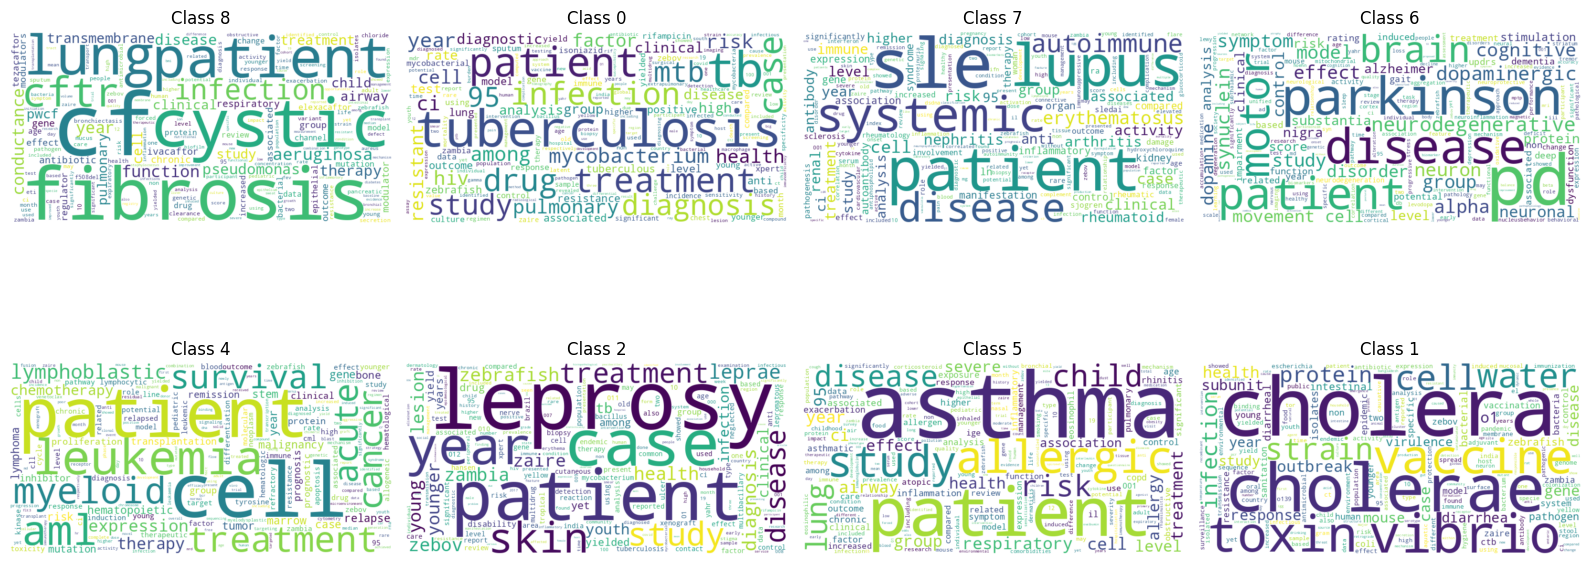

In [ ]:
selected_labels = list(relevant_words_by_class.keys())[:8]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for ax, label in zip(axes.flatten(), selected_labels):
    generate_wordcloud(relevant_words_by_class[label], label, ax)

plt.tight_layout()
plt.show()

---

---

Using only relevant words for solving the classification problem can introduce bias and impact model performance in several ways. Here’s why and how to approach it carefully:

- Loss of Context & Semantic Meaning
By selecting only the most relevant words (e.g., top 500 TF-IDF words), you might remove crucial contextual information.
Sequence models like GRU and LSTM rely on word order and dependencies. If words are extracted without their original sequence, models may struggle to capture relationships between terms;
- Reduced Generalization Ability
Important but low-frequency words may be excluded, leading to poor generalization on unseen data.
Medical terms often appear in different contexts, and missing certain words could impact performance;
- Bias Toward Frequent Words
TF-IDF favors words that appear frequently but uniquely. However, in medical datasets, some rare but critical words might be ignored.
This could skew the model’s learning process, leading to overfitting to certain patterns.

---
#1. Text Preprocessing and Dataset Creation

---

The embeddings used here are essentially sparse integer representations of words. These representations do not capture the semantic relationships between words, such as the similarity between "king" and "queen." Additionally, the vocabulary is fixed during training, which means it does not adapt to new or unseen words that may appear in future datasets.

This method of indexing words and padding sequences is a foundational and straightforward approach to text preprocessing, widely used in simpler models or as a preprocessing step for more complex models.

Dataset Splitting and Preprocessing:

The dataset is split into three parts: 70% for training, 15% for validation, and 15% for testing. The text is tokenized and converted into numerical sequences. Sequences are padded to ensure a uniform input length.
Labels are encoded accordingly.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/diseases_dataset.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38652 entries, 0 to 38651
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PMID                38652 non-null  int64 
 1   Title               38652 non-null  object
 2   Abstract            38652 non-null  object
 3   Keywords            38652 non-null  object
 4   PublicationYear     38652 non-null  int64 
 5   MeSH_Terms          38652 non-null  object
 6   Cleaned_Abstract    38652 non-null  object
 7   Disease             38652 non-null  object
 8   Top_Relevant_Words  38652 non-null  object
 9   Label               38652 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.9+ MB


In [ ]:
X = data["Cleaned_Abstract"].values
y = data["Label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 27056 samples
Validation set: 5798 samples
Test set: 5798 samples


In [ ]:
def tokenize(text):
    """
    Tokenizes the input text by converting it to lowercase and splitting it into words.

    Args:
        text: A string containing the text to be tokenized.

    Returns:
        A list of tokens (words) from the text.
    """
    return re.findall(r'\b\w+\b', text.lower())

In [ ]:
all_tokens = [token for text in X_train for token in tokenize(text)]
vocab = Counter(all_tokens)
filtered_vocab = {word: freq for word, freq in vocab.items() if freq >= 2}
VOCAB_SIZE =  40000

sorted_filtered_vocab = dict(sorted(filtered_vocab.items(), key=lambda item: item[1], reverse=True)[:VOCAB_SIZE])

word_to_index = {word: idx for idx, (word, _) in enumerate(sorted_filtered_vocab.items(), 1)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = len(word_to_index)

index_to_word = {idx: word for word, idx in word_to_index.items()}
print(word_to_index["malaria"])
print(index_to_word[1])

print(index_to_word[300])
print(word_to_index["host"])

1443
patient
relationship
351


In [ ]:
def text_to_sequence(text):
    """
    Converts the tokenized text into a sequence of indices based on a word-to-index mapping.

    Args:
        text: A string containing the text to be converted.

    Returns:
        A list of integers representing the sequence of token indices.
    """
    return [word_to_index.get(token, word_to_index["<UNK>"]) for token in tokenize(text)]

def pad_to_tensor(sequences, max_len=None):
    """
    Pads sequences to the specified maximum length, or truncates them if they exceed it.

    Args:
        sequences: A list of sequences (each sequence is a list of integers).
        max_len: The maximum length to which sequences should be padded. If None, no padding is applied.

    Returns:
        A tensor containing the padded (or truncated) sequences.
    """
    padded_sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    if max_len:
        padded_sequences = [seq[:max_len] for seq in padded_sequences]
        padded_sequences = [
            torch.cat([seq, torch.zeros(max_len - len(seq), dtype=torch.long)], 0) if len(seq) < max_len else seq
            for seq in padded_sequences
        ]

    return torch.stack(padded_sequences)

class TextDataset(Dataset):
    """
    Custom Dataset for handling text data and labels.

    Args:
        X_data: Input features (e.g., tokenized text).
        y_data: Labels corresponding to the text data.
        raw_text_data: (Optional) The raw text data for reference (default is None).
    """
    def __init__(self, X_data, y_data, raw_text_data=None):
        self.X = torch.tensor(X_data, dtype=torch.long)
        self.y = torch.tensor(y_data, dtype=torch.long)
        self.raw_text_data = raw_text_data

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_tensor = self.X[idx]
        target_tensor = self.y[idx]
        raw_text = self.raw_text_data[idx] if self.raw_text_data is not None else None
        return input_tensor, target_tensor, raw_text

Checking the indices of the most relevant words previously obtained in the vocab.

In [ ]:
print(word_to_index["malaria"], word_to_index["infection"], word_to_index["child"], word_to_index["disease"],word_to_index["plasmodium"])
print(word_to_index["prevalence"], word_to_index["protein"], word_to_index["year"], word_to_index["animal"],word_to_index["effect"])

1443 30 71 3 7419
194 52 23 576 35


In [ ]:
X_train_seq = [text_to_sequence(text) for text in X_train]
X_val_seq = [text_to_sequence(text) for text in X_val]
X_test_seq = [text_to_sequence(text) for text in X_test]

print(X_train_seq[0])

[79, 347, 3, 40, 127, 119, 11, 445, 2521, 351, 89, 42, 342, 763, 7415, 333, 5299, 6666, 133, 448, 52, 18, 1464, 79, 4, 499, 295, 233, 31, 6666, 1243, 38, 18, 699, 389, 2717, 119, 11, 445, 161, 4, 2639, 611, 83, 1490, 387, 694, 112, 6666, 79, 412, 1440, 913, 557, 3331, 40001, 622, 728, 128, 4687, 909, 2871, 458, 64, 607, 4412, 219, 4, 190, 19, 7153, 8005, 190, 287, 375, 876, 74, 1354, 458, 93, 4, 229, 9, 654, 132, 6666, 233, 31, 1243, 917, 2298, 213, 38, 4283, 18, 775, 43, 114, 136, 445, 9, 337, 6666, 40, 429, 80, 11, 301, 79]


In [ ]:
max_length = 400

X_train_tensor = pad_to_tensor(X_train_seq, max_len=max_length)
X_val_tensor = pad_to_tensor(X_val_seq, max_len=max_length)
X_test_tensor = pad_to_tensor(X_test_seq, max_len=max_length)

print(f"Train Tensor Shape: {X_train_tensor.shape}, Type: {X_train_tensor.dtype}")
print(f"Validation Tensor Shape: {X_val_tensor.shape}, Type: {X_val_tensor.dtype}")
print(f"Test Tensor Shape: {X_test_tensor.shape}, Type: {X_test_tensor.dtype}")

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

Train Tensor Shape: torch.Size([27056, 400]), Type: torch.int64
Validation Tensor Shape: torch.Size([5798, 400]), Type: torch.int64
Test Tensor Shape: torch.Size([5798, 400]), Type: torch.int64


In [ ]:
batch_size = 16
train_dataset = TextDataset(X_train_tensor, y_train, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<ipython-input-9-275131ece075>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


In [ ]:
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")

Training set size: 27056
Validation set size: 5798
Test set size: 5798
Combined dataset size: 32854


---
Model Architectures: GRU, LSTM, CNN-GRU, and CNN-LSTM


In [ ]:
NUM_CLASSES = len(torch.unique(y_train_tensor))
VOCAB_SIZE = len(word_to_index)

# ============ Define GRU Model ============
class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=NUM_CLASSES, num_layers=1, dropout_prob=0.3):
        super(GRU_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = self.dropout(gru_out[:, -1, :])
        out = self.fc(gru_out)
        return out

# ============ Define LSTM Model ============
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=NUM_CLASSES , num_layers=1, dropout_prob=0.3):
        super(LSTM_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(lstm_out)
        return out

# ============ Define Hybrid CNN-GRU Model ============
class CNN_GRU_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=NUM_CLASSES, num_layers=1, dropout_prob=0.3, kernel_size=3, num_filters=100):
        super(CNN_GRU_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size, padding=1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.gru = nn.GRU(input_size=num_filters, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        conv_input = embedded.permute(0, 2, 1)
        conv_out = self.conv1d(conv_input)
        conv_out = self.relu(conv_out)
        conv_out = self.maxpool(conv_out)
        conv_out = conv_out.permute(0, 2, 1)

        gru_out, _ = self.gru(conv_out)
        gru_out = self.dropout(gru_out[:, -1, :])
        out = self.fc(gru_out)
        return out

# ============ Define Hybrid CNN-LSTM Model ============
class CNN_LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=NUM_CLASSES, num_layers=1, dropout_prob=0.3, num_filters=100, kernel_size=3):
        super(CNN_LSTM_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        conv_out = self.relu(self.conv1(embedded))
        conv_out = self.relu(self.conv2(conv_out))
        conv_out = self.pool(conv_out)

        conv_out = conv_out.permute(0, 2, 1)
        lstm_out, _ = self.lstm(conv_out)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(lstm_out)
        return out

In [ ]:
clip = 5.0

def epoch_time(start_time, end_time):
    """
    Calculates the elapsed time between the start and end time.

    Args:
        start_time: The start time (in seconds).
        end_time: The end time (in seconds).

    Returns:
        elapsed_mins: The elapsed time in minutes.
        elapsed_secs: The elapsed time in seconds.
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y_true):
    """
    Computes accuracy for multi-class classification.
    Args:
        y_pred: Raw logits from the model (before softmax).
        y_true: True class labels (integer class indices).
    Returns:
        Accuracy score.
    """
    y_pred = torch.argmax(y_pred, dim=1)  # Get predicted class index
    correct = (y_pred == y_true).sum().item()
    total = y_true.size(0)  # Number of samples
    return correct / total

def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_accuracy = 0, 0

    for batch in train_loader:
        if len(batch) == 3:
            input_tensor, target_tensor, _ = batch  # Ignore raw_text
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        optimizer.zero_grad()
        output = model(input_tensor)  # Forward pass
        loss = criterion(output, target_tensor)  # Compute loss
        loss.backward()  # Backpropagation

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        batch_accuracy = calculate_accuracy(output, target_tensor)
        total_loss += loss.item()
        total_accuracy += batch_accuracy * len(target_tensor)

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader.dataset)

    return avg_loss, avg_accuracy

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch.
    Args:
        model: Model instance.
        val_loader: DataLoader for validation data.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU.
    Returns:
        Average validation loss, accuracy, and F1-score.
    """
    model.eval()  # Set to evaluation mode
    total_loss, total_accuracy = 0, 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in val_loader:
            if len(batch) == 3:
                input_tensor, target_tensor, _ = batch  # Ignore raw_text
            input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

            output = model(input_tensor)  # Forward pass

            loss = criterion(output, target_tensor)  # Compute loss
            batch_accuracy = calculate_accuracy(output, target_tensor)

            total_loss += loss.item()
            total_accuracy += batch_accuracy * len(target_tensor)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(target_tensor.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader.dataset)

    return avg_loss, avg_accuracy, f1

def get_hidden_states(model, dataloader, device):
    """
    This function extracts the hidden states from a model (either GRU or LSTM) for each sample in the dataloader.
    The hidden states are taken from the last time step of the sequence, which are typically used for classification tasks.

    Args:
        model: A PyTorch model that contains an embedding layer and either a GRU or LSTM layer.
        dataloader: A DataLoader containing batches of input data and their corresponding targets.
        device: The device (CPU or GPU) to run the model on.

    Returns:
        hidden_states: A numpy array containing the hidden states for each sample in the dataloader.
        labels: A numpy array containing the target labels corresponding to each input sample.
    """
    model.eval()
    hidden_states, labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets, _ = batch
            inputs = inputs.to(device)

            embedded = model.embedding(inputs)

            if hasattr(model, "gru"):
                gru_out, _ = model.gru(embedded)
                hidden_state = gru_out[:, -1, :]

            elif hasattr(model, "lstm"):
                lstm_out, (hidden, _) = model.lstm(embedded)
                hidden_state = hidden[-1]

            else:
                raise ValueError("Unsupported model type. Model must contain GRU or LSTM.")

            hidden_states.append(hidden_state.cpu().numpy())
            labels.append(targets.cpu().numpy())

    hidden_states = np.concatenate(hidden_states, axis=0)
    labels = np.concatenate(labels, axis=0)

    return hidden_states, labels

def count_parameters(model):
    """
    Computes the total number of trainable parameters in a model.

    Args:
        model: A PyTorch model instance.

    Returns:
        The total number of trainable parameters in the model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

---
Before training.


In [ ]:
model = GRU_Model(vocab_size=len(word_to_index), embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

GRU_Model(
  (embedding): Embedding(40002, 250)
  (gru): GRU(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)

Total trainable parameters: 10211931


In [ ]:
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for inputs, targets, _ in train_loader:
        inputs = inputs.to(device)
        embedded = model.embedding(inputs)
        embeddings.append(embedded.mean(dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.vstack(embeddings)
labels = np.array(labels)

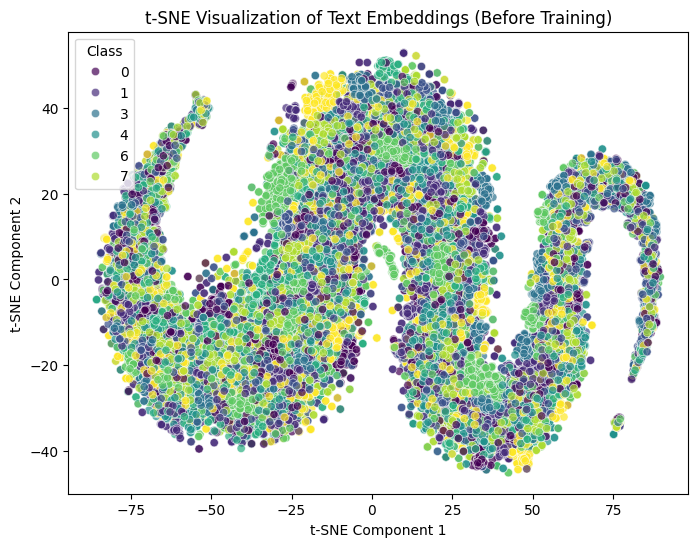

In [ ]:
# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of Text Embeddings (Before Training)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")
plt.show()

---
There is an overall spiral or ‘S’-shaped structure, indicating that the data has a certain degree of organisation even before training. Points from different classes are highly mixed, suggesting that the initial embeddings do not yet capture discriminating structures between classes.
Although the points are mixed, some areas show a higher concentration of certain classes. This could indicate that certain natural relationships already exist in the raw embeddings, but that they are not yet sufficiently discriminating.


---
#2. Validation phase
---

Training and validating model-based GRU

In [ ]:
learning_rate = 1e-4
num_epochs = 13
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 13/13 - Train Loss: 0.6805, Val Loss: 0.6918, Train Acc: 76.12%, Val Acc: 76.11%, Val F1: 74.59%, Time: 0.49 min: 100%|██████████| 13/13 [06:39<00:00, 30.75s/epoch]


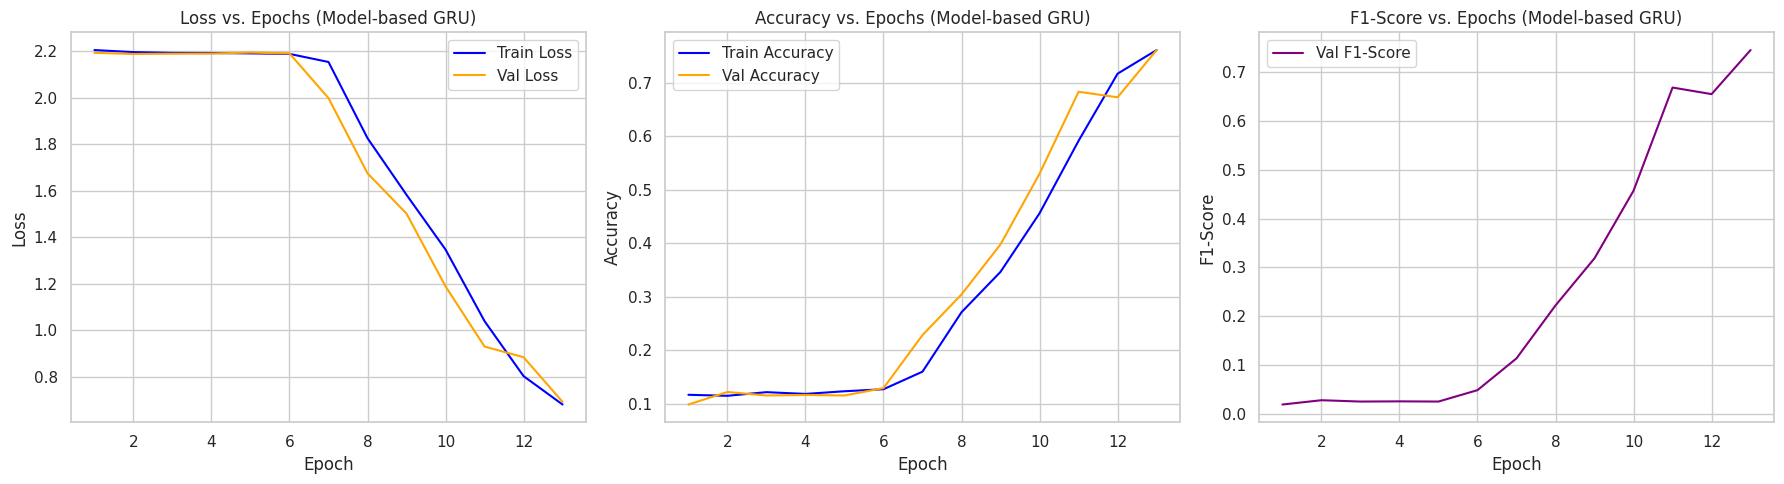

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based GRU)')
plt.legend()

plt.tight_layout()
plt.show()

---
The model provides interesting f1-score and accurarcy value during validation phase before overfitting problem that occurs after some epochs. We will solve this overfitting problem through some techniques as early stopping, dropout and optimising the model parameters.


In [ ]:
hidden_states, labels = get_hidden_states(model, val_loader, device)

tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
tsne_result = tsne.fit_transform(hidden_states)

During forward pass

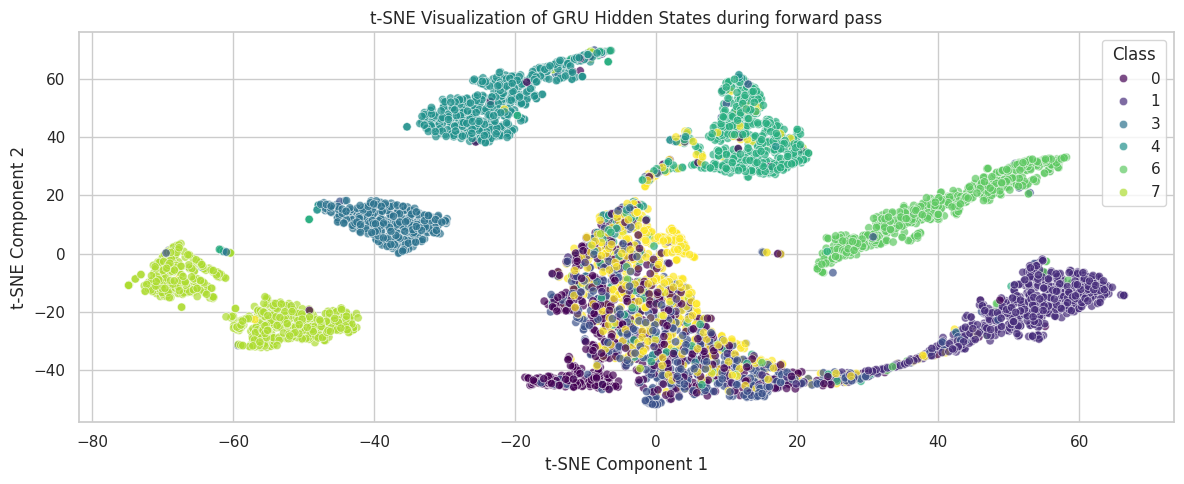

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of GRU Hidden States during forward pass")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")

plt.tight_layout()
plt.show()

---

This t-SNE visualisation indicates that GRU is succeeding in separating the different classes better than in the initial phase. Some classes are clearly distinguishable, while others remain partially mixed, suggesting that there is still room to improve the model or the pre-processing of the data.







Training and validating model-based LSTM

In [ ]:
model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

LSTM_Model(
  (embedding): Embedding(40002, 250)
  (lstm): LSTM(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)

Total trainable parameters: 10281904


In [ ]:
learning_rate = 1e-3
num_epochs = 13
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 13/13 - Train Loss: 0.6429, Val Loss: 0.5851, Train Acc: 73.67%, Val Acc: 80.15%, Val F1: 80.03%, Time: 0.74 min: 100%|██████████| 13/13 [09:39<00:00, 44.57s/epoch]


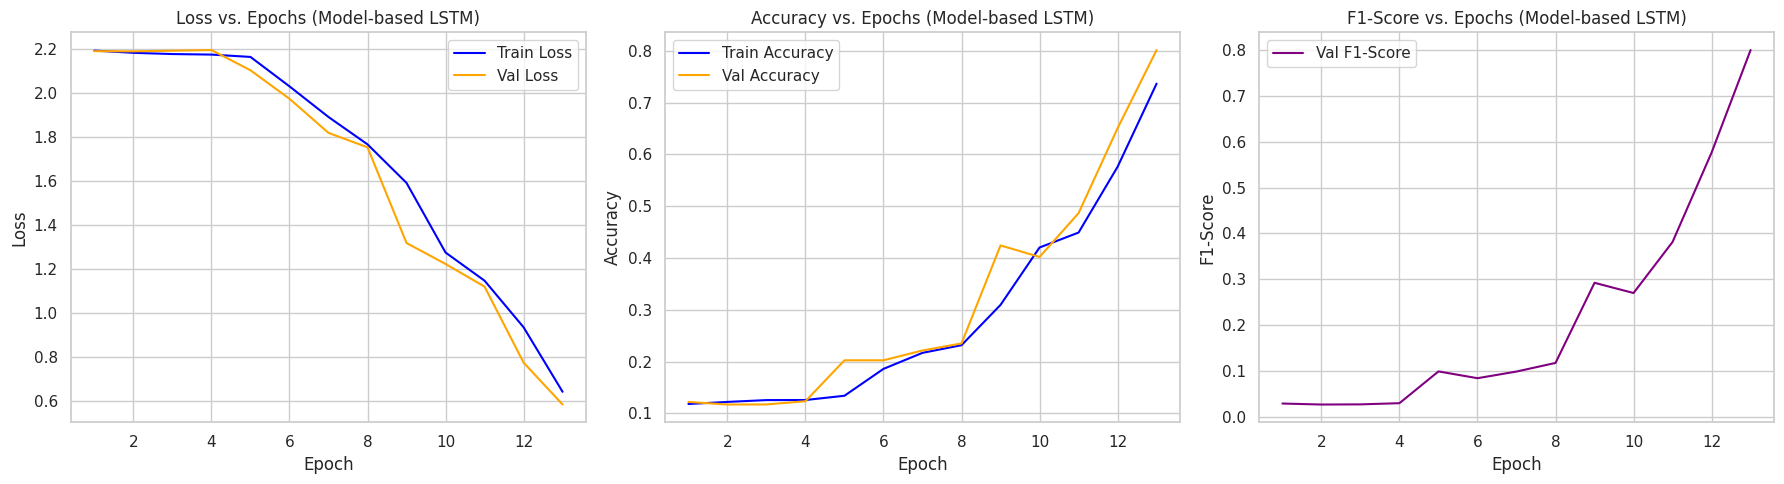

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

---
The model demonstrates promising F1-score and accuracy values during the validation phase before overfitting can become apparent after several epochs. To address this overfitting issue, we will implement strategies such as early stopping, dropout, and optimization of the model parameters.

In [ ]:
hidden_states, labels = get_hidden_states(model, val_loader, device)

tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
tsne_result = tsne.fit_transform(hidden_states)

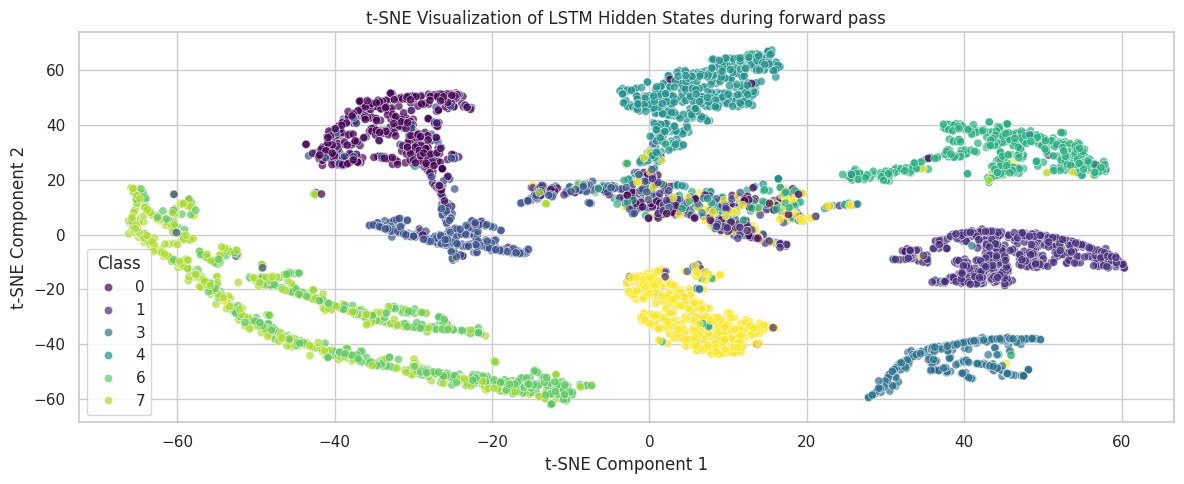

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of LSTM Hidden States during forward pass")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")

plt.tight_layout()
plt.show()

---
This t-SNE visualisation indicates that GRU is succeeding in separating the different classes better than in the initial phase. Some classes are clearly distinguishable, while others remain partially mixed, suggesting that there is still room to improve the model or the pre-processing of the data.


Training and validating model-based GRU-CNN

In [ ]:
model = CNN_GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

CNN_GRU_Model(
  (embedding): Embedding(40002, 250)
  (conv1d): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(100, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)

Total trainable parameters: 10211881


In [ ]:
learning_rate = 7*1e-4
num_epochs = 30
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 30/30 - Train Loss: 0.8631, Val Loss: 0.7851, Train Acc: 65.23%, Val Acc: 66.94%, Val F1: 61.94%, Time: 0.33 min: 100%|██████████| 30/30 [10:08<00:00, 20.28s/epoch]


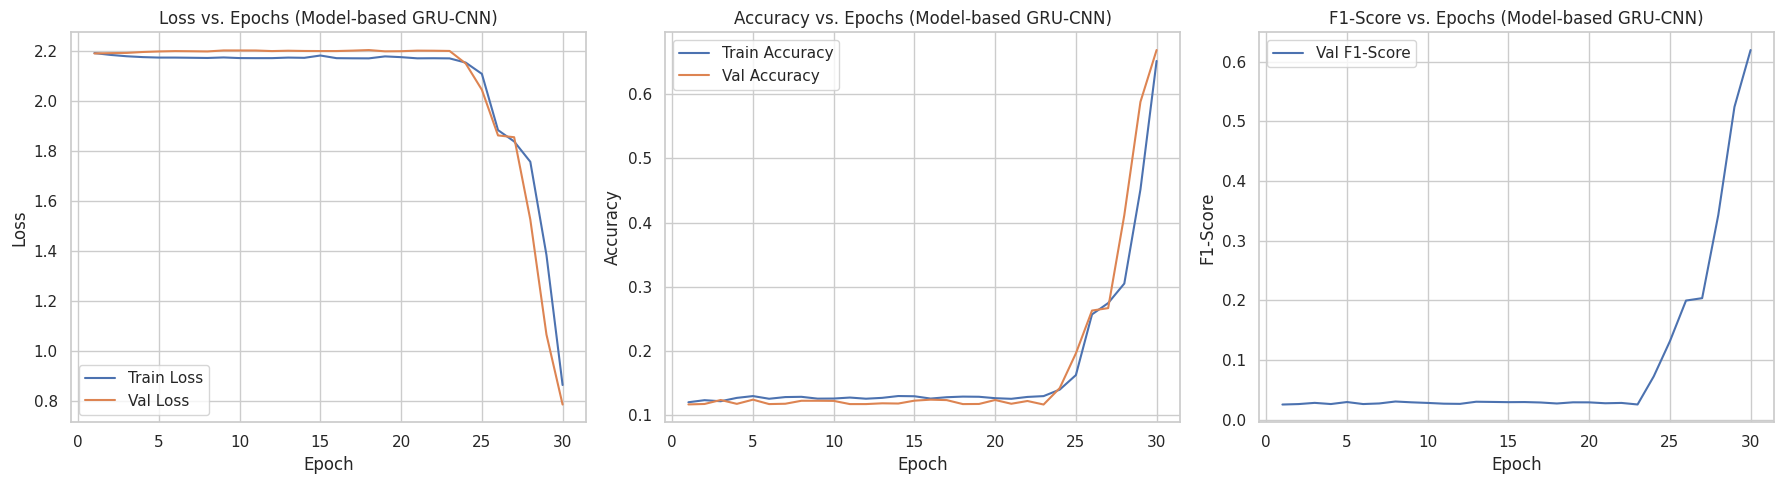

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based GRU-CNN)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based GRU-CNN)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
plt.plot(range(1, len(val_f1s) + 1), val_f1s, label='Val F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based GRU-CNN)')
plt.legend()

plt.tight_layout()
plt.show()

---
The model initially achieves strong F1-score and accuracy metrics during validation; however, signs of overfitting can emerge after multiple epochs. To mitigate this, we will employ techniques like early stopping, dropout, and parameter optimization.


Training and validating model-based LSTM-CNN

In [ ]:
model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.3).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

CNN_LSTM_Model(
  (embedding): Embedding(40002, 250)
  (conv1): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 167, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)

Total trainable parameters: 10286904


In [ ]:
learning_rate = 8*1e-4
num_epochs = 30
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 30/30 - Train Loss: 0.1982, Val Loss: 0.8094, Train Acc: 94.36%, Val Acc: 77.49%, Val F1: 75.87%, Time: 0.53 min: 100%|██████████| 30/30 [14:45<00:00, 29.51s/epoch]


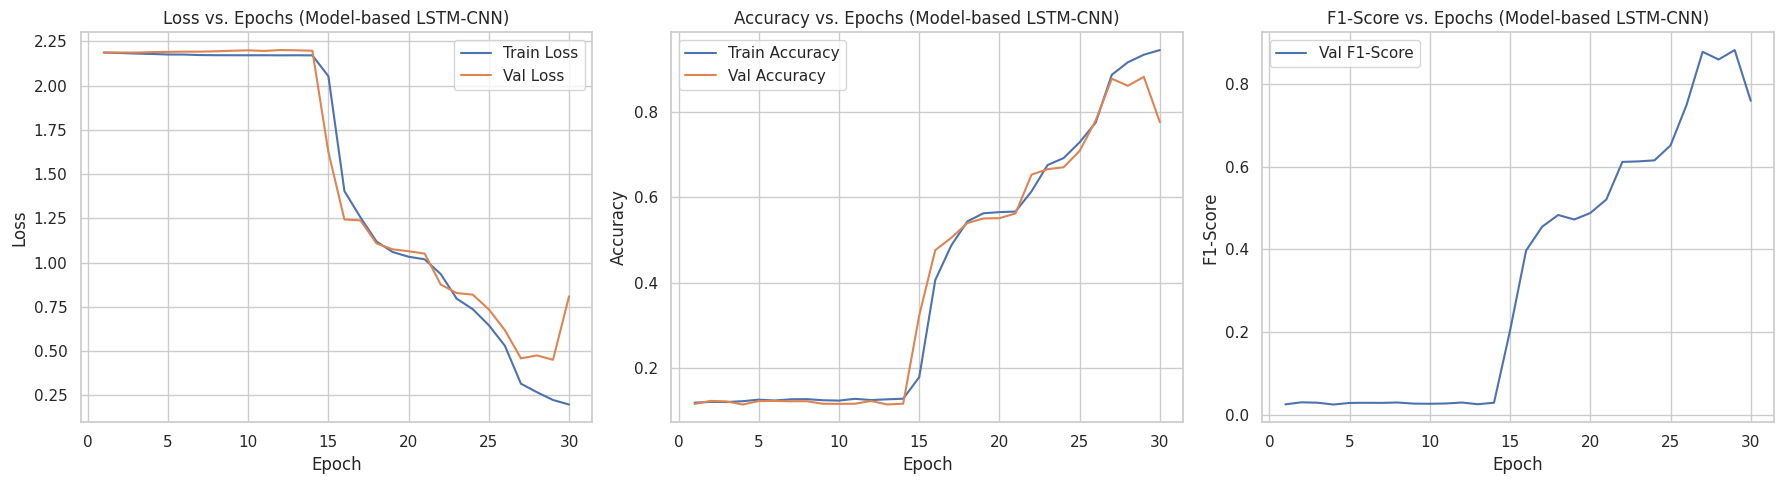

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based LSTM-CNN)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based LSTM-CNN)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
plt.plot(range(1, len(val_f1s) + 1), val_f1s, label='Val F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based LSTM-CNN)')
plt.legend()

plt.tight_layout()
plt.show()

---
During validation, the model exhibits high F1-score and accuracy, but overfitting can become evident after several epochs. To counteract this, we will apply strategies such as early stopping, dropout, and model parameter optimization.


---
#3.Optimisation phase

---

The choice of hyperparameters for the different models was based on an analysis of the results obtained from the reports generated by Weights & Biases (WandB). These reports were used to identify the best-performing configurations in terms of accuracy, F1-score and training stability.

###3.1 Model-based GRU

3.1. a. Optimizer selection

In [ ]:
num_epochs = 15
learning_rate = 1e-4
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, output_dim=len(y_train_tensor), num_layers=1, dropout_prob=0.5).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(project='Multi_Class_Optimizer_Comparison_gru', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 128,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: Adam


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


GRU_Model(
  (embedding): Embedding(40002, 250)
  (gru): GRU(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=27056, bias=True)
)
Total trainable parameters: 14755827


Optimizer: Adam | Epoch 15/15 - Train Loss: 0.2471, Val Loss: 0.4547, Train ACC: 93.29%, Val ACC: 88.46%, Time: 0.58 min: 100%|██████████| 15/15 [08:39<00:00, 34.66s/epoch]


train_acc,▁▁▁▁▂▃▅▆▇██████
train_loss,█▆▆▆▅▄▄▃▂▂▁▁▁▁▁
val_acc,▁▁▁▂▃▄▆▇███████
val_f1,▁▁▁▂▃▄▆▇███████
val_loss,████▆▅▄▂▂▁▁▁▁▁▁
train_acc,0.93292
train_loss,0.24713
val_acc,0.88462
val_f1,0.88509
val_loss,0.45473



🔹 Training with optimizer: RMSprop


GRU_Model(
  (embedding): Embedding(40002, 250)
  (gru): GRU(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=27056, bias=True)
)
Total trainable parameters: 14755827


Optimizer: RMSprop | Epoch 15/15 - Train Loss: 0.3066, Val Loss: 0.5071, Train ACC: 91.80%, Val ACC: 85.93%, Time: 0.54 min: 100%|██████████| 15/15 [08:06<00:00, 32.43s/epoch]


train_acc,▁▁▁▁▂▃▄▆▆▇█████
train_loss,█▇▇▆▆▅▄▃▂▂▂▁▁▁▁
val_acc,▁▁▁▂▃▄▅▇▇██████
val_f1,▁▁▁▂▃▄▅▇▇██████
val_loss,███▇▆▅▄▃▂▂▁▁▁▁▁
train_acc,0.91798
train_loss,0.30658
val_acc,0.85926
val_f1,0.85966
val_loss,0.50711



🔹 Training with optimizer: AdamW


GRU_Model(
  (embedding): Embedding(40002, 250)
  (gru): GRU(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=27056, bias=True)
)
Total trainable parameters: 14755827


Optimizer: AdamW | Epoch 15/15 - Train Loss: 0.1627, Val Loss: 0.4159, Train ACC: 95.91%, Val ACC: 89.63%, Time: 0.60 min: 100%|██████████| 15/15 [09:10<00:00, 36.73s/epoch]


train_acc,▁▁▂▅▇▇▇████████
train_loss,█▆▆▄▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▂▄▇███████████
val_f1,▁▁▄▇███████████
val_loss,██▅▃▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.95908
train_loss,0.16269
val_acc,0.89634
val_f1,0.89697
val_loss,0.41594


---
Adam optimizer is selected.

3.1.b Learning rate value selection

In [ ]:
learning_rates = [5*1e-4, 7*1e-4, 3*1e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with Adam and learning rate: {lr}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, output_dim=len(y_train_tensor), num_layers=1, dropout_prob=0.5).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    wandb.init(project='Multi_Class_learning_rate_tuning_gru', name=f"Adam_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'Adam',
        'model': 'GRU_Model',
        'embedding_dim': 250,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with Adam and learning rate: 0.0005


LR: 0.0005 | Epoch 15/15 - Train Loss: 0.0515, Val Loss: 0.5210, Train ACSA: 98.42%, Val ACSA: 89.60%, Time: 0.58 min: 100%|██████████| 15/15 [08:51<00:00, 35.40s/epoch]


train_acc,▁▇▇▇███████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇██████████▇
val_f1,▁▆▇████████████
val_loss,█▂▁▁▁▁▁▁▂▂▂▂▂▂▃
train_acc,0.98422
train_loss,0.05153
val_acc,0.896
val_f1,0.89603
val_loss,0.52101



🔹 Training with Adam and learning rate: 0.0007


LR: 0.0007 | Epoch 15/15 - Train Loss: 0.0545, Val Loss: 0.4917, Train ACSA: 98.37%, Val ACSA: 90.17%, Time: 0.60 min: 100%|██████████| 15/15 [08:45<00:00, 35.04s/epoch]


train_acc,▁▆▇▇▇▇█████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▇████▇▇▇█▇▇█
val_f1,▁▄▆▇▇▇██▇▇▇█▇▇█
val_loss,▆▃▂▂▁▂▂▃▄▅▆▇▇██
train_acc,0.98366
train_loss,0.05455
val_acc,0.90169
val_f1,0.90223
val_loss,0.49167



🔹 Training with Adam and learning rate: 0.00030000000000000003


LR: 0.00030000000000000003 | Epoch 15/15 - Train Loss: 0.0854, Val Loss: 0.5127, Train ACSA: 97.70%, Val ACSA: 89.32%, Time: 0.58 min: 100%|██████████| 15/15 [08:39<00:00, 34.63s/epoch]


train_acc,▁▆▇▇▇██████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁██████████████
val_f1,▁██████████████
val_loss,█▁▁▁▁▁▁▁▁▁▁▂▂▂▂
train_acc,0.97697
train_loss,0.08536
val_acc,0.89324
val_f1,0.89382
val_loss,0.51271


---
Learning rate value is set to $1 \cdot 10^{-4}$.


3.1.c Embedding value selection

In [ ]:
embedding_dims = [100, 250, 400]
learning_rate = 1e-4
num_epochs = 15

for embedding_dim in embedding_dims:
    print(f"\n🔹 Training with embedding_dim: {embedding_dim}\n")
    run_name = f"GRU_Embedding_{embedding_dim}"
    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim, hidden_dim=167, output_dim=len(y_train_tensor), num_layers=1, dropout_prob=0.5).to(device)
    wandb.init(
        project="Multi_Class_GRU-Embedding-Tuning",
        name=run_name,
        config={
            "embedding_dim": embedding_dim,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 167,
            "dropout": 0.5,
            "optimizer": "Adam"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with embedding_dim: 100



Epoch 15/15 - Train Loss: 0.4497, Val Loss: 0.4941, Train Acc: 82.72%, Val Acc: 82.10%, Val F-1: 81.05%,, Time: 0.49 min: 100%|██████████| 15/15 [07:25<00:00, 29.68s/epoch]


train_acc,▁▁▁▁▂▃▃▄▅▆▆████
train_loss,█▆▆▆▅▅▄▄▃▃▂▂▁▁▁
val_acc,▁▁▁▂▂▄▄▄▆▆▇████
val_f1,▁▁▁▂▂▄▄▄▆▆▇████
val_loss,███▇▆▆▅▄▃▃▂▁▁▁▁
train_acc,0.82721
train_loss,0.44974
val_acc,0.82097
val_f1,0.81049
val_loss,0.49405



🔹 Training with embedding_dim: 250



Epoch 15/15 - Train Loss: 0.1603, Val Loss: 0.4848, Train Acc: 95.79%, Val Acc: 86.79%, Val F-1: 87.01%,, Time: 0.58 min: 100%|██████████| 15/15 [08:40<00:00, 34.69s/epoch]


train_acc,▁▁▁▄▇▇▇████████
train_loss,█▆▆▄▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▁▃▇███████████
val_f1,▁▁▂▇███████████
val_loss,██▇▃▂▁▁▁▁▁▁▁▁▁▁
train_acc,0.95794
train_loss,0.16025
val_acc,0.86789
val_f1,0.87013
val_loss,0.48477



🔹 Training with embedding_dim: 400



Epoch 15/15 - Train Loss: 0.2018, Val Loss: 0.4419, Train Acc: 95.00%, Val Acc: 88.57%, Val F-1: 88.52%,, Time: 0.69 min: 100%|██████████| 15/15 [10:10<00:00, 40.71s/epoch]


train_acc,▁▁▂▄▅▇▇▇███████
train_loss,█▆▆▄▃▃▂▂▁▁▁▁▁▁▁
val_acc,▁▂▄▅▇██████████
val_f1,▁▂▃▄▇██████████
val_loss,██▆▄▃▂▁▁▁▁▁▁▁▁▁
train_acc,0.95003
train_loss,0.20176
val_acc,0.88565
val_f1,0.88515
val_loss,0.44186


---
The larger embedding dimension value, the better is in term of F-1 score and accuracy values during validation phase. But overfitting occurs after some epochs. Thus we set the embedding dimension value to 250.


3.1.d Depth value selection

In [ ]:
depth_values = [1, 2, 3]
learning_rate = 1e-4

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")
    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(
        project="Multi-Class-GRU-Depth-Tuning",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":167,
            "dropout":0.5,
            "optimizer": "Adam"
        }
    )
    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=num_layers, dropout_prob=0.6).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 15/15 - Train Loss: 0.5007, Val Loss: 0.5616, Train Acc: 86.98%, Val Acc: 84.77%, Val F-1: 84.62%,, Time: 0.53 min: 100%|██████████| 15/15 [07:53<00:00, 31.54s/epoch]


train_acc,▁▁▁▁▁▂▂▂▃▃▄▆▆▇█
train_loss,█████▆▆▆▆▅▄▃▂▂▁
val_acc,▁▁▁▁▂▂▂▂▃▄▅▆▆██
val_f1,▁▁▁▁▂▂▂▂▃▃▅▆▆██
val_loss,████▇▆▆▆▅▅▄▂▂▁▁
train_acc,0.86983
train_loss,0.50073
val_acc,0.84771
val_f1,0.8462
val_loss,0.56162



🔹 Training with GRU Depth (num_layers): 2



Epoch 15/15 - Train Loss: 0.5313, Val Loss: 0.5536, Train Acc: 78.83%, Val Acc: 81.61%, Val F-1: 79.72%,, Time: 0.81 min: 100%|██████████| 15/15 [12:13<00:00, 48.91s/epoch]


train_acc,▁▁▁▁▁▂▃▃▄▅▆▇▇██
train_loss,██████▆▅▅▄▃▂▂▁▁
val_acc,▁▁▁▁▁▂▃▃▄▅▆▇▇▇█
val_f1,▁▁▁▁▁▂▃▃▄▅▆▇▇▇█
val_loss,█████▇▆▆▅▄▄▂▂▂▁
train_acc,0.78825
train_loss,0.53126
val_acc,0.81614
val_f1,0.79722
val_loss,0.55359



🔹 Training with GRU Depth (num_layers): 3



Epoch 15/15 - Train Loss: 0.4141, Val Loss: 0.5272, Train Acc: 86.48%, Val Acc: 86.58%, Val F-1: 86.65%,, Time: 1.09 min: 100%|██████████| 15/15 [16:25<00:00, 65.70s/epoch]


train_acc,▁▁▁▁▁▁▂▄▅▆▆▇▇██
train_loss,██████▆▅▄▃▃▂▂▁▁
val_acc,▁▁▁▁▁▂▃▅▆▅▆▇▇▇█
val_f1,▁▁▁▁▁▂▃▄▅▅▆▇▇▇█
val_loss,██████▅▄▃▄▂▂▁▂▁
train_acc,0.86476
train_loss,0.41406
val_acc,0.86582
val_f1,0.86651
val_loss,0.52716


---
Depth value set to 1 can enable to avoid overfitting better than the both other values and also provides good performances.


3.1.e Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]
learning_rate = 1e-4
embedding_dim = 250

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.6).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    wandb.init(
        project="Multi-Class-batch_size_comparison_gru",
        name=f"GRU_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "Adam",
            "hidden_dim": 167,
            "dropout_prob": 0.5
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


GRU_Model(
  (embedding): Embedding(40002, 250)
  (gru): GRU(250, 167, batch_first=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10211931


Epoch 15/15 - Train Loss: 0.2431, Val Loss: 0.4110, Train Acc: 93.90%, Val Acc: 88.50%, Val F-1: 88.72%,, Time: 0.85 min: 100%|██████████| 15/15 [12:54<00:00, 51.66s/epoch]


train_acc,▁▁▁▂▃▄▄▅▇██████
train_loss,███▇▅▅▄▃▂▂▁▁▁▁▁
val_acc,▁▁▁▃▄▄▅▇███████
val_f1,▁▁▁▃▄▄▅▆███████
val_loss,███▆▅▄▄▂▂▁▁▁▁▁▁
train_acc,0.93902
train_loss,0.2431
val_acc,0.88496
val_f1,0.88716
val_loss,0.41101



🔹 Training with batch size: 16


GRU_Model(
  (embedding): Embedding(40002, 250)
  (gru): GRU(250, 167, batch_first=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10211931


Epoch 15/15 - Train Loss: 0.3132, Val Loss: 0.4935, Train Acc: 92.19%, Val Acc: 86.65%, Val F-1: 86.56%,, Time: 0.54 min: 100%|██████████| 15/15 [08:05<00:00, 32.36s/epoch]


train_acc,▁▁▁▁▂▃▄▆▇▇█████
train_loss,█████▆▅▃▂▂▂▁▁▁▁
val_acc,▁▁▁▁▂▄▆▇▇██████
val_f1,▁▁▁▁▂▄▆▇███████
val_loss,████▇▅▄▂▂▁▁▁▁▁▁
train_acc,0.92194
train_loss,0.31324
val_acc,0.86651
val_f1,0.86563
val_loss,0.49354



🔹 Training with batch size: 64


GRU_Model(
  (embedding): Embedding(40002, 250)
  (gru): GRU(250, 167, batch_first=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10211931


Epoch 15/15 - Train Loss: 0.9126, Val Loss: 0.9026, Train Acc: 64.21%, Val Acc: 64.61%, Val F-1: 59.54%,, Time: 0.41 min: 100%|██████████| 15/15 [06:11<00:00, 24.74s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▂▃▅▆▇█
train_loss,██████████▆▄▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▂▄▆▇██
val_f1,▁▁▁▁▁▁▁▁▂▂▄▆▇██
val_loss,█████████▇▅▃▂▁▁
train_acc,0.64215
train_loss,0.91259
val_acc,0.64608
val_f1,0.59542
val_loss,0.9026


---

Batch size values 8 and 16 are more promising. We assign the bathc size value to 16.


###3.2 Model-based LSTM

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

3.2.a Optimizer selection

In [ ]:
num_epochs = 18
learning_rate = 1e-3
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'RMSprop': (optim.RMSprop, {'lr': learning_rate, 'momentum': 0.9}),
    'AdamW': (optim.AdamW, {'lr': learning_rate, 'weight_decay': 1e-5}),
    'Adam': (optim.Adam, {'lr': learning_rate})
}

for optimizer_name, (optimizer_class, optimizer_params) in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device)
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    wandb.init(project='Multi_Class_Optimizer_Comparison_lstm', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'LSTM_Model',
        'embedding_dim': 100,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_postfix({
                'Train Loss': f"{train_loss:.4f}",
                'Val Loss': f"{val_loss:.4f}",
                'Train ACC': f"{train_acc:.2%}",
                'Val ACC': f"{val_acc:.2%}",
                'Time (min)': f"{epoch_duration / 60:.2f}"
            })
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LSTM_Model(
  (embedding): Embedding(40002, 250)
  (lstm): LSTM(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10281904


Optimizer: RMSprop: 100%|██████████| 18/18 [14:04<00:00, 46.92s/epoch, Train Loss=1.8820, Val Loss=1.7860, Train ACC=29.06%, Val ACC=37.63%, Time (min)=0.78]


train_acc,▁▁▂▂▃▃▄▄▄▅▅▆▆▆▇▇██
train_loss,█▇▇▆▆▅▄▄▄▃▃▃▂▂▂▂▁▁
val_acc,▁▁▃▂▃▃▄▅▅▆▅▆▆▆▇▇██
val_f1,▁▁▂▂▄▃▃▄▄▅▅▅▆▆▆▇▇█
val_loss,█▇█▆▆▆▅▄▄▃▄▃▃▂▂▂▁▁
train_acc,0.29062
train_loss,1.88197
val_acc,0.37634
val_f1,0.35954
val_loss,1.78597



🔹 Training with optimizer: AdamW


LSTM_Model(
  (embedding): Embedding(40002, 250)
  (lstm): LSTM(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10281904


Optimizer: AdamW: 100%|██████████| 18/18 [14:15<00:00, 47.55s/epoch, Train Loss=0.1797, Val Loss=0.4349, Train ACC=95.75%, Val ACC=88.62%, Time (min)=0.79]


train_acc,▁▁▁▁▁▂▃▃▃▃▄▅▆▇████
train_loss,█████▇▆▅▅▅▅▃▂▂▁▁▁▁
val_acc,▁▁▁▁▂▂▃▃▃▃▅▆██████
val_f1,▁▁▁▁▂▂▃▃▃▃▅▅██████
val_loss,█████▆▅▅▅▅▃▂▁▁▁▁▁▁
train_acc,0.95753
train_loss,0.17974
val_acc,0.88617
val_f1,0.88621
val_loss,0.43488



🔹 Training with optimizer: Adam


LSTM_Model(
  (embedding): Embedding(40002, 250)
  (lstm): LSTM(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10281904


Optimizer: Adam: 100%|██████████| 18/18 [14:11<00:00, 47.28s/epoch, Train Loss=0.3289, Val Loss=0.4364, Train ACC=91.33%, Val ACC=87.81%, Time (min)=0.80]


train_acc,▁▁▁▁▁▁▁▁▁▂▂▂▃▆▇███
train_loss,█████████▇▇▆▅▃▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▂▂▂▂▅▇████
val_f1,▁▁▁▁▁▁▁▁▁▂▂▂▅▇████
val_loss,████████▇▇▆▆▄▂▁▁▁▁
train_acc,0.91333
train_loss,0.32892
val_acc,0.87806
val_f1,0.87868
val_loss,0.43644


---

Adam optimizer is selected.


3.2.b Leanring rate value selection

In [ ]:
learning_rates = [9*1e-4, 1e-3, 7*1e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with Adam and learning rate: {lr}")

    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    wandb.init(project='Multi_Class_learning_rate_tuning_lstm', name=f"Adam_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'Adam',
        'model': 'LSTM_Model',
        'embedding_dim': 250,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with Adam and learning rate: 0.0009000000000000001


LR: 0.0009000000000000001 | Epoch 18/18 - Train Loss: 0.1311, Val Loss: 0.5490, Train ACSA: 96.99%, Val ACSA: 88.22%, Time: 0.78 min: 100%|██████████| 18/18 [14:06<00:00, 47.00s/epoch]


train_acc,▁▁▁▁▁▁▃▅▆▇████████
train_loss,██████▆▄▃▂▂▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▃▅▆██████████
val_f1,▁▁▁▁▁▂▅▆██████████
val_loss,█████▇▃▃▁▁▁▁▁▁▁▁▁▁
train_acc,0.96988
train_loss,0.13106
val_acc,0.8822
val_f1,0.88215
val_loss,0.54897



🔹 Training with Adam and learning rate: 0.001


LR: 0.001 | Epoch 18/18 - Train Loss: 0.1506, Val Loss: 0.6284, Train ACSA: 96.67%, Val ACSA: 86.69%, Time: 0.78 min: 100%|██████████| 18/18 [14:05<00:00, 46.95s/epoch]


train_acc,▁▁▁▁▂▂▃▅▇▇████████
train_loss,████▇▇▅▄▃▂▂▂▁▁▁▁▁▁
val_acc,▁▁▁▂▂▃▅▆██████████
val_f1,▁▁▁▂▂▃▄▆██████████
val_loss,███▇▇▅▄▃▁▁▁▁▁▁▁▁▁▂
train_acc,0.96666
train_loss,0.15064
val_acc,0.86685
val_f1,0.87024
val_loss,0.62843



🔹 Training with Adam and learning rate: 0.0007


LR: 0.0007 | Epoch 18/18 - Train Loss: 0.3975, Val Loss: 0.7065, Train ACSA: 87.26%, Val ACSA: 80.25%, Time: 0.78 min: 100%|██████████| 18/18 [14:04<00:00, 46.90s/epoch]


train_acc,▁▁▁▁▁▁▁▁▂▃▄▅▅▅▆███
train_loss,████████▇▅▄▄▃▃▃▂▁▁
val_acc,▁▁▁▁▁▁▁▂▃▄▅▅▅▆████
val_f1,▁▁▁▁▁▁▁▂▃▃▄▅▅▆████
val_loss,███████▇▅▄▃▃▃▂▂▁▁▁
train_acc,0.87256
train_loss,0.39753
val_acc,0.80252
val_f1,0.77725
val_loss,0.70651


---

Learning rate value is set to $9 \cdot 10^{-4}$.


3.2.c Embedding dimension value selection

In [ ]:
embedding_dims = [100, 250, 400]
learning_rate = 9*1e-4

for embedding_dim in embedding_dims:
    print(f"\n🔹 Training with embedding_dim: {embedding_dim}\n")
    run_name = f"LSTM_Embedding_{embedding_dim}"
    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device)
    wandb.init(
        project="Multi_Class_LSTM-Embedding-Tuning",
        name=run_name,
        config={
            "embedding_dim": embedding_dim,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 167,
            "dropout": 0.5,
            "optimizer": "Adam"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with embedding_dim: 100



Epoch 18/18 - Train Loss: 0.6987, Val Loss: 0.8109, Train Acc: 71.17%, Val Acc: 67.37%, Val F-1: 61.12%,, Time: 0.69 min: 100%|██████████| 18/18 [12:30<00:00, 41.70s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▂▂▃▅▅▆▇▇█
train_loss,██████████▇▆▄▃▂▂▁▁
val_acc,▁▁▁▁▁▁▁▁▁▂▂▅▅▅▆▇██
val_f1,▁▁▁▁▁▁▁▁▁▂▂▅▅▅▆▇██
val_loss,█████████▇▆▄▃▃▂▁▁▁
train_acc,0.71175
train_loss,0.69868
val_acc,0.67368
val_f1,0.61117
val_loss,0.81086



🔹 Training with embedding_dim: 250



Epoch 18/18 - Train Loss: 0.1766, Val Loss: 0.4008, Train Acc: 95.92%, Val Acc: 89.72%, Val F-1: 89.70%,, Time: 0.78 min: 100%|██████████| 18/18 [14:05<00:00, 46.98s/epoch]


train_acc,▁▁▁▁▁▁▁▁▂▂▅▇▇█████
train_loss,████████▇▆▄▃▂▂▁▁▁▁
val_acc,▁▁▁▁▁▁▁▂▂▄▇███████
val_f1,▁▁▁▁▁▁▁▁▂▄▇███████
val_loss,████████▆▅▂▁▁▁▁▁▁▁
train_acc,0.95923
train_loss,0.17656
val_acc,0.89721
val_f1,0.89703
val_loss,0.40077



🔹 Training with embedding_dim: 400



Epoch 18/18 - Train Loss: 0.2345, Val Loss: 0.5600, Train Acc: 95.24%, Val Acc: 88.27%, Val F-1: 88.26%,, Time: 0.88 min: 100%|██████████| 18/18 [15:54<00:00, 53.05s/epoch]


train_acc,▁▁▁▁▁▁▁▁▂▃▅▆▇█████
train_loss,████████▇▅▄▃▂▂▁▁▁▁
val_acc,▁▁▁▁▁▁▁▂▃▅▆▇██████
val_f1,▁▁▁▁▁▁▁▂▂▅▅▇██████
val_loss,███████▇▆▄▃▂▁▁▁▁▁▁
train_acc,0.95243
train_loss,0.23452
val_acc,0.88272
val_f1,0.88262
val_loss,0.56003


---

Embedding dimension value is set to 250.


3.2.d Depth value selection

In [ ]:
depth_values = [1, 2, 3]
learning_rate = 9*1e-4
loss_function = torch.nn.CrossEntropyLoss()
num_epochs = 18

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")

    run_name = f"LSTM_Depth_{num_layers}"
    wandb.init(
        project="Multi-Class-LSTM-Depth-Tuning",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":167,
            "dropout":0.5,
            "optimizer": "Adam"
        }
    )
    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=num_layers, dropout_prob=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 18/18 - Train Loss: 0.2583, Val Loss: 0.5886, Train Acc: 94.14%, Val Acc: 86.25%, Val F-1: 86.19%,, Time: 0.78 min: 100%|██████████| 18/18 [14:07<00:00, 47.06s/epoch]


train_acc,▁▁▁▁▁▁▂▃▄▅▆▇██████
train_loss,██████▇▅▅▄▃▂▂▁▁▁▁▁
val_acc,▁▁▁▁▁▂▃▄▅▆▇▇█▇████
val_f1,▁▁▁▁▁▂▃▄▅▆▇▇█▇████
val_loss,█████▇▆▄▃▃▂▂▁▂▁▁▁▁
train_acc,0.94142
train_loss,0.25834
val_acc,0.86254
val_f1,0.86191
val_loss,0.58862



🔹 Training with GRU Depth (num_layers): 2



Epoch 18/18 - Train Loss: 0.2867, Val Loss: 0.4737, Train Acc: 92.88%, Val Acc: 87.55%, Val F-1: 87.55%,, Time: 1.32 min: 100%|██████████| 18/18 [23:49<00:00, 79.43s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▂▂▃▄▄▅▆▇█
train_loss,█████████▆▆▆▅▄▃▂▂▁
val_acc,▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆▇██
val_f1,▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆▇██
val_loss,████████▆▆▅▅▄▃▃▂▁▁
train_acc,0.92881
train_loss,0.28674
val_acc,0.87547
val_f1,0.87547
val_loss,0.47369



🔹 Training with GRU Depth (num_layers): 3



Epoch 18/18 - Train Loss: 1.3296, Val Loss: 1.1601, Train Acc: 38.86%, Val Acc: 49.97%, Val F-1: 42.13%,, Time: 1.84 min: 100%|██████████| 18/18 [32:57<00:00, 109.84s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▆▆█
train_loss,█████████████▆▅▃▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▅█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄█
val_loss,█████████████▅▅▃▂▁
train_acc,0.3886
train_loss,1.32962
val_acc,0.49966
val_f1,0.42129
val_loss,1.16012


---

We set the depth value to 1 since the three different values enable to get the same model performances.


3.2.e Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]
embedding_dim = 250

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    wandb.init(
        project="Multi-Class-batch_size_comparison_lstm",
        name=f"LSTM_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "Adam",
            "hidden_dim": 167,
            "dropout_prob": 0.5
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


LSTM_Model(
  (embedding): Embedding(40002, 250)
  (lstm): LSTM(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10281904


Epoch 18/18 - Train Loss: 0.2940, Val Loss: 0.5014, Train Acc: 92.60%, Val Acc: 88.19%, Val F-1: 88.24%,, Time: 0.93 min: 100%|██████████| 18/18 [16:49<00:00, 56.06s/epoch]


train_acc,▁▁▁▁▁▂▂▃▄▄▄▅▆▇▇███
train_loss,█████▇▆▆▄▄▄▃▃▂▂▁▁▁
val_acc,▁▁▁▁▂▂▂▄▄▄▄▅▆▇████
val_f1,▁▁▁▁▁▂▂▃▃▃▄▅▆▇████
val_loss,████▇▇▆▄▄▃▃▃▂▂▁▁▁▁
train_acc,0.92597
train_loss,0.29401
val_acc,0.88186
val_f1,0.88238
val_loss,0.50142



🔹 Training with batch size: 16


LSTM_Model(
  (embedding): Embedding(40002, 250)
  (lstm): LSTM(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10281904


Epoch 18/18 - Train Loss: 0.1543, Val Loss: 0.6013, Train Acc: 96.66%, Val Acc: 81.20%, Val F-1: 78.01%,, Time: 0.76 min: 100%|██████████| 18/18 [13:42<00:00, 45.72s/epoch]


train_acc,▁▁▁▁▁▁▂▂▃▅▆▇██████
train_loss,██████▇▇▆▄▃▂▂▁▁▁▁▁
val_acc,▁▁▁▁▁▂▂▃▅▆▇██████▇
val_f1,▁▁▁▁▁▂▂▃▅▆▇██████▇
val_loss,██████▇▆▄▃▂▁▁▁▁▁▁▂
train_acc,0.96662
train_loss,0.15425
val_acc,0.812
val_f1,0.78013
val_loss,0.60134



🔹 Training with batch size: 64


LSTM_Model(
  (embedding): Embedding(40002, 250)
  (lstm): LSTM(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10281904


Epoch 18/18 - Train Loss: 0.2995, Val Loss: 0.6140, Train Acc: 92.84%, Val Acc: 80.84%, Val F-1: 78.42%,, Time: 0.56 min: 100%|██████████| 18/18 [10:00<00:00, 33.39s/epoch]


train_acc,▁▁▁▁▁▁▁▁▂▂▂▄▆▇▇▇██
train_loss,████████▇▇▆▅▃▂▂▂▁▁
val_acc,▁▁▁▁▁▁▁▂▂▂▄▆▆███▇█
val_f1,▁▁▁▁▁▁▁▂▂▂▄▆▆███▇█
val_loss,███████▇▇▆▅▃▂▁▁▁▂▁
train_acc,0.92841
train_loss,0.29948
val_acc,0.80838
val_f1,0.78422
val_loss,0.61402


---
Batch size value is set to 16.


###3.3 Model-based GRU-CNN

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

3.3.a optimizer selection

In [ ]:
num_epochs = 30
learning_rate = 7*1e-4
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = CNN_GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(project='Multi_Class_Optimizer_Comparison_cnn_gru', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'CNN_GRU_Model',
        'embedding_dim': 128,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


CNN_GRU_Model(
  (embedding): Embedding(40002, 250)
  (conv1d): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(100, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10211881


Optimizer: RMSprop | Epoch 30/30 - Train Loss: 0.0363, Val Loss: 0.5766, Train ACC: 98.70%, Val ACC: 90.10%, Time: 0.35 min: 100%|██████████| 30/30 [10:48<00:00, 21.61s/epoch]


train_acc,▁▆▆▇▇█████████████████████████
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▆█▇▄▇█▄▆▃▆▅▁▃▃▃▅▂▄▅▅▄▃▁▄▃▃▂▄▄
val_f1,▄▆█▇▄▇█▄▆▃▆▅▁▃▃▃▅▂▄▅▅▄▄▁▄▃▃▂▄▄
val_loss,▂▁▁▂▂▃▃▄▄▅▅▆▅▆▆▅▆▆▇▆▅▅▇▇▇█▇█▇▇
train_acc,0.98703
train_loss,0.03631
val_acc,0.901
val_f1,0.90086
val_loss,0.57656



🔹 Training with optimizer: Adam


CNN_GRU_Model(
  (embedding): Embedding(40002, 250)
  (conv1d): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(100, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10211881


Optimizer: Adam | Epoch 30/30 - Train Loss: 0.0435, Val Loss: 0.5671, Train ACC: 98.50%, Val ACC: 88.77%, Time: 0.38 min: 100%|██████████| 30/30 [11:15<00:00, 22.51s/epoch]


train_acc,▁▁▁▁▁▁▁▁▂▁▅▇██████████████████
train_loss,██████████▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▂▂▂████████████████████
val_f1,▁▁▁▁▁▁▂▂▂▂████████████████████
val_loss,███████▇▇▇▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂
train_acc,0.98503
train_loss,0.04352
val_acc,0.88772
val_f1,0.8873
val_loss,0.5671



🔹 Training with optimizer: AdamW


CNN_GRU_Model(
  (embedding): Embedding(40002, 250)
  (conv1d): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(100, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10211881


Optimizer: AdamW | Epoch 30/30 - Train Loss: 0.0581, Val Loss: 0.5236, Train ACC: 98.23%, Val ACC: 88.31%, Time: 0.39 min: 100%|██████████| 30/30 [11:39<00:00, 23.31s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▃▇▇█████████
train_loss,██████████████▇▇▇▇▆▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▇███████████
val_f1,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂████████████
val_loss,████████████▇▇█▇▇▇▂▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.9823
train_loss,0.05805
val_acc,0.88306
val_f1,0.88347
val_loss,0.52362


---
We select Adam as optimizer.


3.3.b Learning rate value selection

In [ ]:
learning_rates = [5*1e-4, 7*1e-4, 3*1e-4]
num_epochs = 15

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = CNN_GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device)

    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    wandb.init(project='Multi_Class_learning_rate_tuning_cnn_gru', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMSprop',
        'model': 'GRU_Model',
        'embedding_dim': 250,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with AdamW and learning rate: 0.0005


LR: 0.0005 | Epoch 15/15 - Train Loss: 2.1690, Val Loss: 2.2031, Train ACSA: 12.71%, Val ACSA: 12.23%, Time: 0.35 min: 100%|██████████| 15/15 [05:13<00:00, 20.91s/epoch]


train_acc,▃▁▂▅▅▇▆▇▅▆▆▆▇█▆
train_loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁
val_acc,▇▂█▂▂▁█▂█▁▇▁▂▂▇
val_f1,▅▁▆▂▂▂▅▂▆▁█▂▃▃▇
val_loss,▁▂▃▄▆▆▆▆▇▇▇█▇▇█
train_acc,0.12714
train_loss,2.16902
val_acc,0.12228
val_f1,0.03105
val_loss,2.20309



🔹 Training with AdamW and learning rate: 0.0007


LR: 0.0007 | Epoch 15/15 - Train Loss: 0.0496, Val Loss: 0.4628, Train ACSA: 98.43%, Val ACSA: 89.91%, Time: 0.35 min: 100%|██████████| 15/15 [05:15<00:00, 21.00s/epoch]


train_acc,▁▆▆▇▇██████████
train_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▂▅█▆▃▅▄▃▆▅▃▃▁▁▂
val_f1,▂▅█▆▃▅▃▂▆▅▂▂▁▁▂
val_loss,▂▁▁▂▃▄▆▆▇▆▇▇▇█▇
train_acc,0.98433
train_loss,0.04956
val_acc,0.8991
val_f1,0.89894
val_loss,0.46282



🔹 Training with AdamW and learning rate: 0.00030000000000000003


LR: 0.00030000000000000003 | Epoch 15/15 - Train Loss: 1.9004, Val Loss: 1.9412, Train ACSA: 23.87%, Val ACSA: 22.65%, Time: 0.35 min: 100%|██████████| 15/15 [05:34<00:00, 22.27s/epoch]


train_acc,▁▁▁▁▁▂▁▁▁▂▆████
train_loss,█████████▇▃▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▄█████
val_f1,▁▁▁▁▁▁▁▁▁▄█████
val_loss,█████████▅▁▁▁▁▁
train_acc,0.23873
train_loss,1.90043
val_acc,0.22646
val_f1,0.16987
val_loss,1.94116


---

Learning rate value is set to $7 \cdot 10^{-4}$.


3.3.c Embedding dimension value selection

In [ ]:
embedding_dims = [100, 250, 400]
learning_rate = 7*1e-4

for embedding_dim in embedding_dims:
    print(f"\n🔹 Training with embedding_dim: {embedding_dim}\n")
    run_name = f"CNN_GRU_Embedding_{embedding_dim}"
    model = CNN_GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device)
    wandb.init(
        project="Multi_Class_CNN_GRU_Embedding_Tuning",
        name=run_name,
        config={
            "embedding_dim": embedding_dim,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 167,
            "dropout": 0.5,
            "optimizer": "Adam"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with embedding_dim: 100



Epoch 15/15 - Train Loss: 2.1693, Val Loss: 2.2027, Train Acc: 12.42%, Val Acc: 11.69%, Val F-1: 2.75%,, Time: 0.29 min: 100%|██████████| 15/15 [04:26<00:00, 17.78s/epoch]


train_acc,▁▁▁▆▅▄▆▅▇▅▆▇██▄
train_loss,█▇▅▃▃▂▂▂▂▂▂▁▁▁▁
val_acc,▇▂▃▇▂██▂▁█▇▂▇▂▃
val_f1,▆▁▃▆▂█▆▃▁█▇▃█▃▅
val_loss,▁▁▃▄▅▆▅▇▆▇▆█▇▇█
train_acc,0.12419
train_loss,2.16934
val_acc,0.11694
val_f1,0.02754
val_loss,2.20266



🔹 Training with embedding_dim: 250



Epoch 15/15 - Train Loss: 1.9526, Val Loss: 1.9477, Train Acc: 22.20%, Val Acc: 21.90%, Val F-1: 12.93%,, Time: 0.38 min: 100%|██████████| 15/15 [05:37<00:00, 22.50s/epoch]


train_acc,▁▁▁▁▁▁▂▂▁▁▁▁▁▂█
train_loss,███████████▇▇▇▁
val_acc,▂▂▁▁▁▁▁▁▁▁▁▁▁▄█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▅█
val_loss,█████████████▅▁
train_acc,0.22202
train_loss,1.95258
val_acc,0.21904
val_f1,0.12934
val_loss,1.9477



🔹 Training with embedding_dim: 400



Epoch 15/15 - Train Loss: 1.9323, Val Loss: 1.9450, Train Acc: 22.80%, Val Acc: 22.59%, Val F-1: 13.30%,, Time: 0.46 min: 100%|██████████| 15/15 [06:55<00:00, 27.71s/epoch]


train_acc,▁▁▁▁▂▁▁▁▂▁▂▂▄▆█
train_loss,███████████▇▅▃▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▂▅██
val_f1,▁▁▁▁▁▁▁▁▁▁▁▃▆██
val_loss,███████████▇▄▁▁
train_acc,0.22801
train_loss,1.93234
val_acc,0.22594
val_f1,0.133
val_loss,1.94499


---

Embedding dimension value is set to 250.


3.3.d Depth value selection

In [ ]:
depth_values = [1, 2, 3]
learning_rate = 7*1e-4

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")

    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(
        project="Multi-Class-CNN-GRU-Depth-Tuning",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":167,
            "dropout":0.5,
            "optimizer": "AdamW"
        }
    )
    model = CNN_GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=num_layers, dropout_prob=0.5).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with CNN-GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 15/15 - Train Loss: 1.2633, Val Loss: 1.3337, Train Acc: 49.35%, Val Acc: 46.93%, Val F-1: 41.98%,, Time: 0.39 min: 100%|██████████| 15/15 [05:46<00:00, 23.13s/epoch]


train_acc,▁▁▁▁▁▁▁▁▂▂▃▃▆██
train_loss,████████▇▇▆▆▄▂▁
val_acc,▁▁▁▁▁▁▁▂▂▂▃▃▇██
val_f1,▁▁▁▁▁▁▁▂▂▂▃▃▇██
val_loss,███████▇▇▇▆▆▂▁▁
train_acc,0.49353
train_loss,1.26326
val_acc,0.4693
val_f1,0.41978
val_loss,1.33367



🔹 Training with GRU Depth (num_layers): 2



Epoch 15/15 - Train Loss: 2.1719, Val Loss: 2.1971, Train Acc: 12.79%, Val Acc: 11.52%, Val F-1: 2.64%,, Time: 0.53 min: 100%|██████████| 15/15 [07:56<00:00, 31.74s/epoch]


train_acc,▁▄▃▅▄▅▇▄█▅█▄▇█▇
train_loss,█▇▆▄▃▂▂▂▂▂▁▁▁▁▁
val_acc,▃▁▂▇▇▃▂▇▇▇█▇██▁
val_f1,▂▁▁▇▅▃▄▅▇▆▆▅▅█▂
val_loss,▁▁▂▃▃▇█▅▆▆█▇▇▇▇
train_acc,0.12792
train_loss,2.17189
val_acc,0.11521
val_f1,0.02637
val_loss,2.19707



🔹 Training with GRU Depth (num_layers): 3



Epoch 15/15 - Train Loss: 2.1732, Val Loss: 2.1960, Train Acc: 12.38%, Val Acc: 11.62%, Val F-1: 2.71%,, Time: 0.67 min: 100%|██████████| 15/15 [10:08<00:00, 40.58s/epoch]


train_acc,▁▁▅▃▄▃▄▄▇▆▅▇▆█▅
train_loss,█▇▇▆▆▅▅▄▃▃▃▂▂▁▁
val_acc,▇▂▁▂▇▂▂▃█▂█▂▇█▂
val_f1,▃▂▁▂▅▃▃▄█▃▇▂▇▇▄
val_loss,▃▂▂▁▂▄▅▃▅▆▆▇█▆▇
train_acc,0.12382
train_loss,2.1732
val_acc,0.11625
val_f1,0.02711
val_loss,2.19598


---

Depth value is set to 1.


###3.4 Model-based LSTM-CNN

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

3.4.a Optimizer selection

In [ ]:
num_epochs = 25
learning_rate = 8*1e-4
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.3).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(project='Multi_Class_Optimizer_Comparison_cnn_lstm', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'CNN_LSTM_Model',
        'embedding_dim': 128,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: Adam


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CNN_LSTM_Model(
  (embedding): Embedding(40002, 250)
  (conv1): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 167, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10286904


Optimizer: Adam | Epoch 25/25 - Train Loss: 0.5634, Val Loss: 0.6903, Train ACC: 76.37%, Val ACC: 72.02%, Time: 0.51 min: 100%|██████████| 25/25 [12:39<00:00, 30.38s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▅▆▆▆▇██
train_loss,████████████████▆▅▄▃▃▃▂▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▅▆▆▆▆███
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▆▆▆███
val_loss,███████████████▇▆▄▃▃▃▃▁▁▁
train_acc,0.76368
train_loss,0.56343
val_acc,0.72025
val_f1,0.68326
val_loss,0.69027



🔹 Training with optimizer: RMSprop


CNN_LSTM_Model(
  (embedding): Embedding(40002, 250)
  (conv1): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 167, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10286904


Optimizer: RMSprop | Epoch 25/25 - Train Loss: 0.0528, Val Loss: 0.6898, Train ACC: 98.38%, Val ACC: 88.96%, Time: 0.48 min: 100%|██████████| 25/25 [12:02<00:00, 28.91s/epoch]


train_acc,▁▁▄▅▆▇▇██████████████████
train_loss,██▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▅▇▇████████████████████
val_f1,▁▂▅▆▇████████████████████
val_loss,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
train_acc,0.98381
train_loss,0.05285
val_acc,0.88962
val_f1,0.89076
val_loss,0.68979



🔹 Training with optimizer: AdamW


CNN_LSTM_Model(
  (embedding): Embedding(40002, 250)
  (conv1): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 167, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10286904


Optimizer: AdamW | Epoch 25/25 - Train Loss: 0.1459, Val Loss: 0.4376, Train ACC: 96.33%, Val ACC: 89.10%, Time: 0.52 min: 100%|██████████| 25/25 [12:53<00:00, 30.94s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▄▄▅▅▅▅▅▇█
train_loss,███████████▇▆▆▅▅▄▄▄▄▄▄▄▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▄▅▄▄▅▄▅▅██
val_f1,▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▄▄▄▄▄▄▅██
val_loss,██████████▇▆▅▅▅▄▄▄▄▄▄▄▄▁▁
train_acc,0.9633
train_loss,0.14591
val_acc,0.891
val_f1,0.89135
val_loss,0.43755


---

AdamW optimizer is selected.


3.4.b Learning rate value selection

In [ ]:
learning_rates = [3*1e-4, 5*1e-4, 7*1e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with AdamW and learning rate: {lr}")

    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.3).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    wandb.init(project='Multi_Class_learning_rate_tuning_cnn_lstm', name=f"AdamW_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'AdamW',
        'model': 'LSTM_CNN_Model',
        'embedding_dim': 250,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with AdamW and learning rate: 0.00030000000000000003


LR: 0.00030000000000000003 | Epoch 25/25 - Train Loss: 0.1463, Val Loss: 0.3696, Train ACSA: 96.23%, Val ACSA: 89.55%, Time: 0.52 min: 100%|██████████| 25/25 [13:01<00:00, 31.25s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▆▇██████
train_loss,████████████████▇▃▂▂▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅████████
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄████████
val_loss,████████████████▄▁▁▁▁▁▁▁▁
train_acc,0.9623
train_loss,0.1463
val_acc,0.89548
val_f1,0.89507
val_loss,0.36959



🔹 Training with AdamW and learning rate: 0.0005


LR: 0.0005 | Epoch 25/25 - Train Loss: 0.0735, Val Loss: 0.4485, Train ACSA: 97.88%, Val ACSA: 89.69%, Time: 0.52 min: 100%|██████████| 25/25 [12:54<00:00, 30.97s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▇▇████████
train_loss,██████████████▅▂▂▂▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████████
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████████
val_loss,██████████████▁▁▁▁▁▁▁▁▂▂▁
train_acc,0.97878
train_loss,0.07354
val_acc,0.89686
val_f1,0.89713
val_loss,0.44855



🔹 Training with AdamW and learning rate: 0.0007


LR: 0.0007 | Epoch 25/25 - Train Loss: 0.3111, Val Loss: 0.5246, Train ACSA: 87.99%, Val ACSA: 86.63%, Time: 0.52 min: 100%|██████████| 25/25 [12:53<00:00, 30.92s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▅▆▆▇▇▇▇▇█
train_loss,██████████████▆▄▃▃▂▂▂▂▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▅▅▆▇▇▇▇▇▇█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▅▅▆▆▆▆▆▆▆█
val_loss,██████████████▄▃▃▃▂▂▂▂▂▂▁
train_acc,0.87988
train_loss,0.31106
val_acc,0.86633
val_f1,0.86807
val_loss,0.52463


---

Learning rate value is set to $7 \cdot 10^{-4}$.


3.4.c Embedding dimension value selection

In [ ]:
embedding_dims = [100, 250, 400]
learning_rate = 8*1e-4

for embedding_dim in embedding_dims:
    print(f"\n🔹 Training with embedding_dim: {embedding_dim}\n")
    run_name = f"CNN_LSTM_Embedding_{embedding_dim}"
    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim, hidden_dim=167, num_layers=1, dropout_prob=0.3).to(device)
    wandb.init(
        project="Multi_Class_CNN_LSTM_Embedding_Tuning",
        name=run_name,
        config={
            "embedding_dim": embedding_dim,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 167,
            "dropout": 0.5,
            "optimizer": "AdamW"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with embedding_dim: 100



Epoch 25/25 - Train Loss: 0.0747, Val Loss: 0.4278, Train Acc: 97.86%, Val Acc: 89.13%, Val F-1: 89.24%,, Time: 0.42 min: 100%|██████████| 25/25 [10:37<00:00, 25.50s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▅▇▇▇█████████
train_loss,████████████▄▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▂▇████████████
val_f1,▁▁▁▁▁▁▁▁▁▁▁▂▇████████████
val_loss,███████████▆▂▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.9786
train_loss,0.07467
val_acc,0.89134
val_f1,0.89235
val_loss,0.42782



🔹 Training with embedding_dim: 250



Epoch 25/25 - Train Loss: 1.3718, Val Loss: 1.3329, Train Acc: 44.10%, Val Acc: 46.05%, Val F-1: 39.25%,, Time: 0.52 min: 100%|██████████| 25/25 [13:11<00:00, 31.67s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄█
train_loss,███████████████████████▅▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▇█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▇█
val_loss,██████████████████████▇▂▁
train_acc,0.44097
train_loss,1.37184
val_acc,0.4605
val_f1,0.3925
val_loss,1.33294



🔹 Training with embedding_dim: 400



Epoch 25/25 - Train Loss: 0.0735, Val Loss: 0.4607, Train Acc: 97.90%, Val Acc: 88.96%, Val F-1: 88.91%,, Time: 0.60 min: 100%|██████████| 25/25 [16:01<00:00, 38.46s/epoch]


train_acc,▁▁▁▁▁▁▁▃▄▄▄▆▇████████████
train_loss,███████▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▂▄▄▄▅▇█████████████
val_f1,▁▁▁▁▁▁▂▄▄▄▄▇█████████████
val_loss,██████▆▅▄▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.97901
train_loss,0.0735
val_acc,0.88962
val_f1,0.88913
val_loss,0.46067


---
We assign 250 to embedding dimension value.

3.4.e Depth value selection

In [ ]:
depth_values = [1, 2, 3]
learning_rate = 8*1e-4

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")

    run_name = f"CNN_LSTM_Depth_{num_layers}"
    wandb.init(
        project="Multi-Class-CNN-LSTM-Depth-Tuning",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":167,
            "dropout":0.5,
            "optimizer": "AdamW"
        }
    )
    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=num_layers, dropout_prob=0.3).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with CNN-LSTM Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 25/25 - Train Loss: 0.0664, Val Loss: 0.5079, Train Acc: 97.92%, Val Acc: 88.44%, Val F-1: 88.46%,, Time: 0.52 min: 100%|██████████| 25/25 [12:54<00:00, 30.99s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▃▆▇▇███████████
train_loss,██████████▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▅▇█████████████
val_f1,▁▁▁▁▁▁▁▁▁▁▅▇█████████████
val_loss,██████████▄▂▁▁▁▁▁▁▁▁▁▁▁▁▂
train_acc,0.97919
train_loss,0.06637
val_acc,0.88444
val_f1,0.88457
val_loss,0.50792



🔹 Training with GRU Depth (num_layers): 2



Epoch 25/25 - Train Loss: 0.0636, Val Loss: 0.4536, Train Acc: 98.14%, Val Acc: 89.15%, Val F-1: 89.17%,, Time: 0.79 min: 100%|██████████| 25/25 [20:13<00:00, 48.56s/epoch]


train_acc,▁▁▁▁▁▁▂▄▇▇▇██████████████
train_loss,██████▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▃▆█████████████████
val_f1,▁▁▁▁▁▁▃▆█████████████████
val_loss,██████▆▃▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
train_acc,0.98137
train_loss,0.06359
val_acc,0.89151
val_f1,0.89171
val_loss,0.45358



🔹 Training with GRU Depth (num_layers): 3



Epoch 25/25 - Train Loss: 0.3241, Val Loss: 0.5361, Train Acc: 90.54%, Val Acc: 85.32%, Val F-1: 85.32%,, Time: 1.05 min: 100%|██████████| 25/25 [26:28<00:00, 63.52s/epoch]


train_acc,▁▁▁▁▁▁▁▂▂▂▂▃▄▄▅▆▇▇▇▇█████
train_loss,███████▇▇▇▆▆▅▄▃▃▃▂▂▂▂▁▁▁▁
val_acc,▁▁▁▁▁▁▁▂▂▂▃▃▅▅▆▆▇▇███████
val_f1,▁▁▁▁▁▁▁▂▂▂▂▃▄▅▆▆▇████████
val_loss,███████▇▆▆▆▅▄▃▃▃▂▂▂▁▁▁▁▁▁
train_acc,0.90542
train_loss,0.32412
val_acc,0.85323
val_f1,0.85318
val_loss,0.53609


---
The depth value is set to 1.


---
#4. Test phase

---

## Metrics


1. **Accuracy**:

Accuracy is the proportion of correct predictions among all predictions.

$$
\text{Accuracy} = \frac{\sum_{i=1}^{N} \mathbb{1}(y_i = \hat{y}_i)}{N}
$$

where $y_i$ is the true class of the \( i \)-th example, $\hat{y}_i$ is the predicted class for that example, and \( N \) is the total number of examples.

2. **Recall**:

The recall for each class \( c \) is the proportion of true positives among the actual elements of that class.

$$
\text{Recall}_c = \frac{TP_c}{TP_c + FN_c}
$$

where $TP_c$ is the number of true positives for class \( c \), and $FN_c$ is the number of false negatives for class \( c \).

The **global recall** in a multi-class problem is typically the average of the recalls for the different classes.

$$
\text{Recall}_{\text{global}} = \frac{1}{C} \sum_{c=1}^{C} \text{Recall}_c
$$

3. **Precision**:

Precision for each class \( c \) is the proportion of true positives among the elements predicted to be of that class.

$$
\text{Precision}_c = \frac{TP_c}{TP_c + FP_c}
$$

where $FP_c$ is the number of false positives for class \( c \).

The **global precision** in a multi-class problem is typically the average of the precision values for the different classes.

$$
\text{Precision}_{\text{global}} = \frac{1}{C} \sum_{c=1}^{C} \text{Precision}_c
$$

4. **Balanced Accuracy**:

Balanced accuracy is the average of recalls across classes, which gives equal importance to each class even if some classes are imbalanced.

$$
\text{Balanced Accuracy} = \frac{1}{C} \sum_{c=1}^{C} \text{Recall}_c
$$

5. **F1-Score**:

The F1-score is the harmonic mean of precision and recall for each class \( c \).

$$
F1_c = 2 \times \frac{\text{Precision}_c \times \text{Recall}_c}{\text{Precision}_c + \text{Recall}_c}
$$

The **global F1-score** in a multi-class problem is typically the average of the F1-scores for the different classes.

$$
F1_{\text{global}} = \frac{1}{C} \sum_{c=1}^{C} F1_c
$$

The overfitting prevention process relies on using CrossEntropyLoss, a standard loss function for multi-class classification problems. The model monitors two main criteria to detect overfitting: the loss gap and the accuracy gap between training and test data.

The loss_gap_ratio, set to 1.25, flags overfitting if the test loss becomes more than 1.25 times the training loss.

The accuracy gap (set to 5%) between training and test accuracy is also monitored to detect potential overfitting.

If either of these criteria is exceeded, early stopping is triggered to prevent further overfitting, and the model is saved before it becomes overly specialized to the training data. This ensures better generalization of the model

In [ ]:
def reinitialize_weights(model):
    """Reinitializes the model's weights by calling reset_parameters() for each layer that supports it."""
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def test_epoch(model, test_loader, criterion, device):
    """
    Validate the model for one epoch, including precision, F1, balanced accuracy, and recall.
    Args:
        model: Model instance.
        test_loader: DataLoader for test data.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU.
    Returns:
        Average test loss, accuracy, F1-score, balanced accuracy, Recall, and Precision.
    """
    model.eval()  # Set model to evaluation mode
    total_loss, total_accuracy = 0, 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_tensor, target_tensor, _ = batch  # Ignore raw_text
            input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

            output = model(input_tensor)  # Forward pass
            loss = criterion(output, target_tensor)  # Compute loss
            batch_accuracy = calculate_accuracy(output, target_tensor)

            total_loss += loss.item()
            total_accuracy += batch_accuracy * len(target_tensor)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(target_tensor.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)

    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader.dataset)

    return avg_loss, avg_accuracy, f1, balanced_acc, recall, precision

In [ ]:
models = {
    "CNN_LSTM": CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.3).to(device),
    "CNN_GRU": CNN_GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device),
    "LSTM": LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device),
    "GRU": GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.5).to(device),
}

optimizers = {
    "CNN_LSTM": optim.AdamW(models["CNN_LSTM"].parameters(), lr=7e-4),
    "CNN_GRU": optim.Adam(models["CNN_GRU"].parameters(), lr=7e-4),
    "LSTM": optim.Adam(models["LSTM"].parameters(), lr=9e-4),
    "GRU": optim.Adam(models["GRU"].parameters(), lr=1e-4),
}

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
loss_gap_ratio = 1.25
ax_accuracy_gap = 5
num_epochs = 40

model_metrics = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name} model...\n")
    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    reinitialize_weights(model)

    optimizer = optimizers[model_name]
    wandb.init(
        project='Multi-Class-Models-Train-Test-No-Embedding',
        name=f"{model_name}_Training",
        config={'learning_rate': 7e-4 if model_name in ["CNN_LSTM", "CNN_GRU"] else (9e-4 if model_name == "LSTM" else 1e-4),
                'num_epochs': num_epochs, 'num_layers': 1}
    )

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    test_f1s, test_balanced_accs, test_recalls, test_precisions = [], [], [], []

    saved_once = False
    with tqdm(total=num_epochs, desc=f"Training {model_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, combined_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            test_loss, test_acc, test_f1, test_balanced_acc, test_recall, test_precision = test_epoch(model, test_loader, loss_function, device)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
            test_f1s.append(test_f1)
            test_balanced_accs.append(test_balanced_acc)
            test_recalls.append(test_recall)
            test_precisions.append(test_precision)

            end_time = time.time()
            epoch_duration = end_time - start_time
            wandb.log({
                "train_loss": train_loss,
                "test_loss": test_loss,
                "train_acc": train_acc,
                "test_acc": test_acc,
                "test_f1": test_f1,
                "test_balanced_acc": test_balanced_acc,
                "test_recall": test_recall,
                "test_precision": test_precision
            })

            if (test_loss > train_loss * loss_gap_ratio or (train_acc > test_acc and train_acc - test_acc > ax_accuracy_gap / 100)) and not saved_once:
                torch.save(model.state_dict(), f"{model_name}_multi_class_loss_gap_accuracy_gap_5%.pth")
                saved_once = True
                print(f"Early stopping triggered at epoch {epoch+1}")
                print(f"Model {model_name} saved with loss gap > 1.25 or accuracy gap > 5% at epoch {epoch}.")
                print(f"Model metrics: \n"
                      f"Test Accuracy: {test_acc:.2%}, Test F1: {test_f1:.2%}, "
                      f"Test Balanced Accuracy: {test_balanced_acc:.2%}, Test Recall: {test_recall:.2%}, Test Precision: {test_precision:.2%}")
                break

            if epoch == num_epochs - 1 and not saved_once:
                torch.save(model.state_dict(), f"{model_name}_multi_class_final.pth")
                print(f"Model {model_name} saved at the end of epoch {num_epochs}.")
                print(f"Model metrics: \n"
                      f"Test Accuracy: {test_acc:.2%}, Test F1: {test_f1:.2%}, "
                      f"Test Balanced Accuracy: {test_balanced_acc:.2%}, Test Recall: {test_recall:.2%}, Test Precision: {test_precision:.2%}")

            pbar.set_description(
                f"{model_name} Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Test Acc: {test_acc:.2%}, Test F1: {test_f1:.2%}, "
                f"Test Balanced Acc: {test_balanced_acc:.2%}, Test Recall: {test_recall:.2%}, Test Precision: {test_precision:.2%}, "
                f"Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

        model_metrics[model_name] = {
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies,
            "test_f1s": test_f1s,
            "test_balanced_accs": test_balanced_accs,
            "test_recalls": test_recalls,
            "test_precisions": test_precisions
        }


Training CNN_LSTM model...

CNN_LSTM_Model(
  (embedding): Embedding(40002, 250)
  (conv1): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 167, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10286904


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CNN_LSTM Epoch 35/40 - Train Loss: 0.6295, Test Loss: 0.4116, Train Acc: 74.49%, Test Acc: 87.75%, Test F1: 87.99%, Test Balanced Acc: 88.08%, Test Recall: 87.75%, Test Precision: 88.83%, Time: 0.64 min:  88%|████████▊ | 35/40 [23:17<03:19, 39.93s/epoch]

Early stopping triggered at epoch 36
Model CNN_LSTM saved with loss gap > 1.25 or accuracy gap > 5% at epoch 35.
Model metrics: 
Test Accuracy: 88.13%, Test F1: 88.36%, Test Balanced Accuracy: 88.40%, Test Recall: 88.13%, Test Precision: 89.34%

Training CNN_GRU model...

CNN_GRU_Model(
  (embedding): Embedding(40002, 250)
  (conv1d): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(100, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10211881


test_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▆▆▆██
test_balanced_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▆▅▆██
test_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▆▆▆██
test_loss,█████████████████████████████▆▄▃▃▃▁▁
test_precision,▁▁▃▂▁▁▁▂▂▂▂▂▂▁▂▁▂▁▁▂▁▃▃▁▂▂▂▁▂▃▄▆▆▆██
test_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▆▆▆██
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▅▆▆▆█
train_loss,██████████████████████████████▅▄▃▃▂▁
test_acc,0.88134
test_balanced_acc,0.88397
test_f1,0.88363


CNN_GRU Epoch 29/40 - Train Loss: 0.3471, Test Loss: 0.4286, Train Acc: 89.28%, Test Acc: 86.58%, Test F1: 86.91%, Test Balanced Acc: 86.91%, Test Recall: 86.58%, Test Precision: 87.88%, Time: 0.44 min:  72%|███████▎  | 29/40 [13:23<05:04, 27.71s/epoch]

Early stopping triggered at epoch 30
Model CNN_GRU saved with loss gap > 1.25 or accuracy gap > 5% at epoch 29.
Model metrics: 
Test Accuracy: 86.77%, Test F1: 87.11%, Test Balanced Accuracy: 87.09%, Test Recall: 86.77%, Test Precision: 88.35%

Training LSTM model...

LSTM_Model(
  (embedding): Embedding(40002, 250)
  (lstm): LSTM(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10281904


test_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▇████
test_balanced_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▇████
test_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▇████
test_loss,█████████████████████▆▆▆▆▃▂▁▁▁
test_precision,▁▁▁▁▁▂▂▁▁▂▁▁▂▂▂▁▂▂▂▃▂▃▃▄▄▇████
test_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▇████
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▇███
train_loss,█████████████████████▇▆▆▆▅▂▂▁▁
test_acc,0.86771
test_balanced_acc,0.87087
test_f1,0.8711


LSTM Epoch 9/40 - Train Loss: 0.5325, Test Loss: 0.5627, Train Acc: 81.39%, Test Acc: 87.29%, Test F1: 87.32%, Test Balanced Acc: 87.54%, Test Recall: 87.29%, Test Precision: 87.63%, Time: 0.93 min:  22%|██▎       | 9/40 [09:17<31:59, 61.93s/epoch]

Early stopping triggered at epoch 10
Model LSTM saved with loss gap > 1.25 or accuracy gap > 5% at epoch 9.
Model metrics: 
Test Accuracy: 88.13%, Test F1: 88.36%, Test Balanced Accuracy: 88.46%, Test Recall: 88.13%, Test Precision: 88.88%

Training GRU model...

GRU_Model(
  (embedding): Embedding(40002, 250)
  (gru): GRU(250, 167, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10211931


test_acc,▁▁▁▂▃▄▅▇██
test_balanced_acc,▁▁▁▂▃▄▅▇██
test_f1,▁▁▁▂▂▄▅▇██
test_loss,████▆▄▃▂▁▁
test_precision,▁▂▂▂▂▄▅▆██
test_recall,▁▁▁▂▃▄▅▇██
train_acc,▁▁▁▁▂▃▅▆▇█
train_loss,████▇▅▄▃▂▁
test_acc,0.88134
test_balanced_acc,0.88455
test_f1,0.88361


GRU Epoch 14/40 - Train Loss: 0.4257, Test Loss: 0.4716, Train Acc: 88.97%, Test Acc: 87.27%, Test F1: 87.39%, Test Balanced Acc: 87.57%, Test Recall: 87.27%, Test Precision: 87.73%, Time: 0.63 min:  35%|███▌      | 14/40 [09:23<17:27, 40.29s/epoch]

Early stopping triggered at epoch 15
Model GRU saved with loss gap > 1.25 or accuracy gap > 5% at epoch 14.
Model metrics: 
Test Accuracy: 87.74%, Test F1: 87.78%, Test Balanced Accuracy: 88.00%, Test Recall: 87.74%, Test Precision: 88.00%


In [ ]:
with open("model_metrics.pkl", "wb") as f:
    pickle.dump(model_metrics, f)

with open("model_metrics.pkl", "rb") as f:
    model_metrics = pickle.load(f)

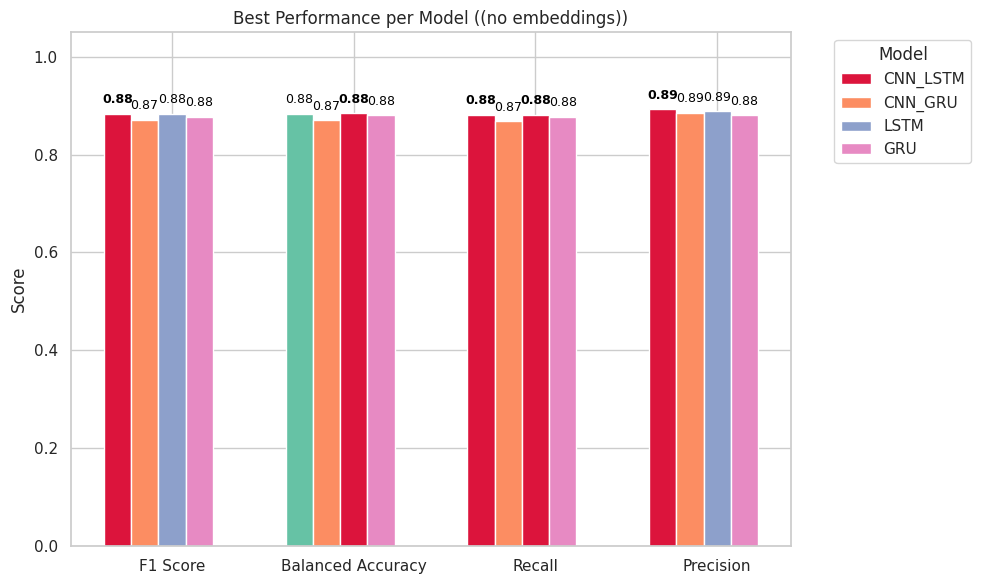

In [ ]:
summary_metrics = {
    "Model": [],
    "F1 Score": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": []
}

for model_name, metrics in model_metrics.items():
    summary_metrics["Model"].append(model_name)
    summary_metrics["F1 Score"].append(max(metrics["test_f1s"]))
    summary_metrics["Balanced Accuracy"].append(max(metrics["test_balanced_accs"]))
    summary_metrics["Recall"].append(max(metrics["test_recalls"]))
    summary_metrics["Precision"].append(max(metrics["test_precisions"]))

df_summary = pd.DataFrame(summary_metrics)
df_melted = df_summary.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

models = df_summary["Model"].tolist()
palette = sns.color_palette("Set2", len(models))

# Plotting each metric group
for i, metric in enumerate(df_melted["Metric"].unique()):
    data = df_melted[df_melted["Metric"] == metric]
    max_score = data["Score"].max()

    for j, (index, row) in enumerate(data.iterrows()):
        color = "crimson" if row["Score"] == max_score else palette[models.index(row["Model"])]
        bar = ax.bar(
            x=i - 0.3 + j * (0.6 / len(models)),
            height=row["Score"],
            width=0.6 / len(models),
            color=color,
            label=row["Model"] if i == 0 else "",
        )
        ax.text(
            x=bar[0].get_x() + bar[0].get_width() / 2,
            y=row["Score"] + 0.015,
            s=f"{row['Score']:.2f}",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black',
            fontweight='bold' if row["Score"] == max_score else 'normal'
        )

ax.set_xticks(range(len(df_melted["Metric"].unique())))
ax.set_xticklabels(df_melted["Metric"].unique())
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Best Performance per Model ((no embeddings))")
ax.grid(True, axis='y')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("best_model_performance_comparison_all_values.png")
plt.show()

---


---

---
#5. Analyzing the Distribution of Misclassifications

---

All these models outperform the others. Therefore, for the criticizing phase, we choose the GRU model.

In [ ]:
def plot_confusion_matrix(labels, pred_labels, num_classes = NUM_CLASSES):
    """Plots the confusion matrix with actual labels and predicted labels."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    cm_display.plot(values_format='d', cmap='Blues', ax=ax)
    plt.title('Confusion Matrix (no embeddings)')
    plt.show()

def evaluate_and_analyze(model, test_loader, device, num_classes = NUM_CLASSES):
    """Evaluates and analyzes model performance on the test set."""
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []
    all_indices = []

    top_correct = []
    top_wrong = []

    with torch.no_grad():
        for idx, (inputs, labels, raw_text) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_indices.extend(range(len(labels)))

            correct_indices = (preds == labels).nonzero(as_tuple=True)[0]
            wrong_indices = (preds != labels).nonzero(as_tuple=True)[0]

            # Store correct predictions
            for correct_idx in correct_indices[:]:
                top_correct.append({
                    'index': correct_idx.item(),
                    'true_label': labels[correct_idx].item(),
                    'predicted_label': preds[correct_idx].item(),
                    'probability': probs[correct_idx, preds[correct_idx]].cpu().item(),
                    'text': raw_text[correct_idx.item()] if raw_text is not None else None
                })

            # Store wrong predictions
            for wrong_idx in wrong_indices[:]:
                top_wrong.append({
                    'index': wrong_idx.item(),
                    'true_label': labels[wrong_idx].item(),
                    'predicted_label': preds[wrong_idx].item(),
                    'probability': probs[wrong_idx, preds[wrong_idx]].cpu().item(),
                    'text': raw_text[wrong_idx.item()] if raw_text is not None else None
                })

    df_correct = pd.DataFrame(top_correct)
    df_wrong = pd.DataFrame(top_wrong)

    class_report = classification_report(all_labels, all_preds, output_dict=True)
    df_results = pd.DataFrame(class_report).transpose()
    plot_confusion_matrix(all_labels, all_preds, num_classes)

    return df_results, df_correct, df_wrong, all_labels, all_preds

def plot_wrong_distributions(wrong_indices, all_labels, all_preds, num_classes =  NUM_CLASSES):
    """Plots the distribution of wrong predictions for each class."""
    class_counts_wrong = defaultdict(int)

    for idx in wrong_indices:
        true_label = all_labels[idx]
        class_counts_wrong[true_label] += 1

    class_labels = sorted(class_counts_wrong.keys())
    counts = [class_counts_wrong[label] for label in class_labels]
    colors = sns.color_palette("husl", len(class_labels))

    class_names = [f"Class {label}" for label in class_labels]

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    plt.barh(class_names, counts, color=colors)
    plt.xlabel('Number of Wrong Predictions')
    plt.ylabel('Crop Disease Classes')
    plt.title('Distribution of Wrong Predictions for Each Class')

    for i, (count, name) in enumerate(zip(counts, class_names)):
        plt.text(count, i, str(count), ha='left', va='center')

    plt.show()

In [ ]:
model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.3).to(device)
model.load_state_dict(torch.load("/content/CNN_LSTM_multi_class_loss_gap_accuracy_gap_5%.pth"))

<All keys matched successfully>

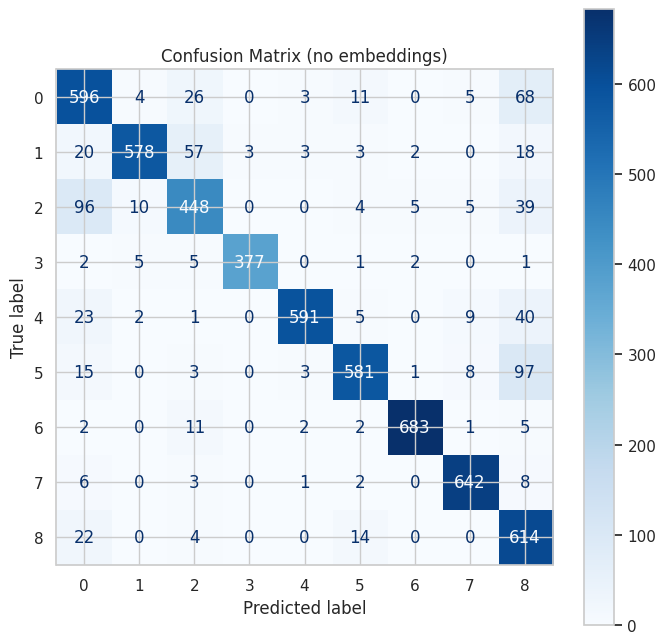

In [ ]:
df_results, df_correct, df_wrong, all_labels, all_preds= evaluate_and_analyze(model, test_loader, device)

# Confusion Matrix Analysis

## General Observations
The confusion matrix evaluates the performance of a classification model applied to different diseases.

## Specific Observations
- **Tuberculosis (Class 0):** 596 correctly classified, but 196 misclassified.  
- **Cholera (Class 1):** 578 correctly classified, with a few errors.  
- **Leprosy (Class 2):** 448 correctly classified, but 110 misclassified.  
- **Ebola (Class 3):** 377 correctly classified, with minor errors.  
- **Leukemia (Class 4):** 591 correctly classified, some misclassifications.  
- **Asthma (Class 5):** 581 correctly classified, a few misclassifications.  
- **Parkinson (Class 6):** 683 correctly classified, very few errors.  
- **Lupus (Class 7):** 642 correctly classified, with slight misclassifications.  
- **Cystic Fibrosis (Class 8):** 614 correctly classified, but some errors.  

## Notable Misclassifications
- **Tuberculosis (0)** is often confused with **Leprosy (2)** (196 errors).  
- **Asthma (5)** shows confusion with **Tuberculosis (0)** and **Leukemia (4)**.  
- **Cystic Fibrosis (8)** is sometimes misclassified as **Leukemia (4)**.  

## Conclusion
The model performs well overall, especially for **Parkinson, Lupus, and Asthma**. However, **Tuberculosis and Cystic Fibrosis** exhibit significant misclassifications. Further improvements could be achieved through additional training data or more refined features to better distinguish between similar diseases.




In [ ]:
df_wrong.tail()

,index,true_label,predicted_label,probability,text
683,1,2,0,0.951295,introduction need shorten treatment duration t...
684,9,2,0,0.702771,background rifampicin resistance rr associated...
685,13,4,8,0.588390,covid 19 convalescent plasma ccp important the...
686,14,2,8,0.509169,background maculopapular drug eruption mpe rea...
687,3,2,0,0.951143,tuberculosis tb covid 19 become significant he...


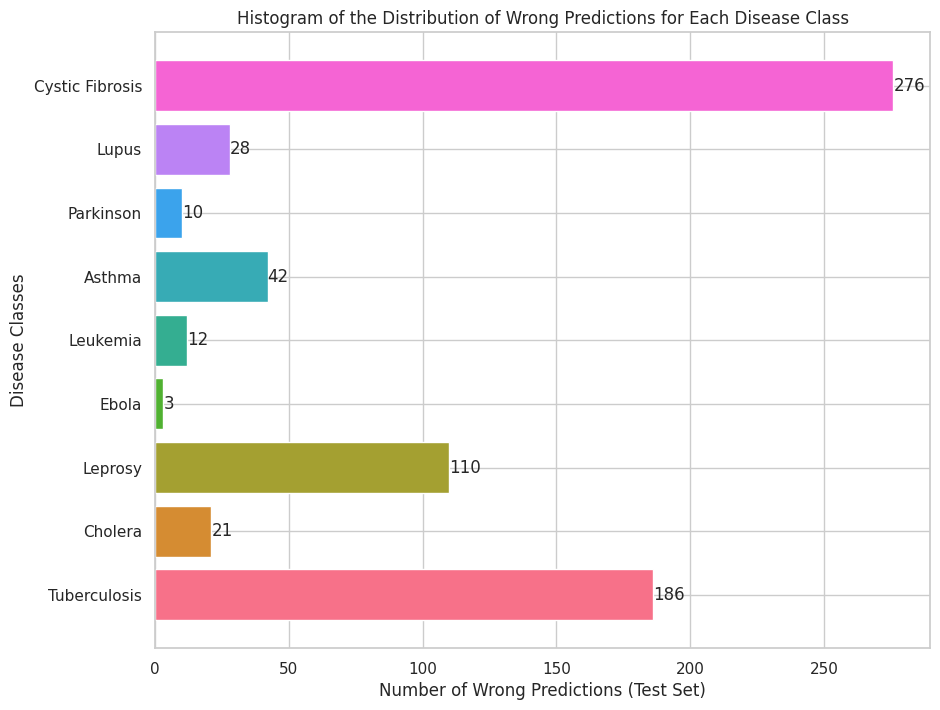

In [ ]:
wrong_df = pd.DataFrame({'predictions': all_preds, 'labels': all_labels})
wrong_df['wrong'] = wrong_df['predictions'] != wrong_df['labels']

wrong_class_counts = defaultdict(int)
for _, row in wrong_df.iterrows():
    if row['wrong']:
        wrong_class_counts[row['predictions']] += 1

wrong_class_labels = sorted(wrong_class_counts.keys())
wrong_counts = [wrong_class_counts[label] for label in wrong_class_labels]
wrong_colors = sns.color_palette("husl", len(wrong_class_labels))

class_names_dict = {
    0: 'Tuberculosis',
    1: 'Cholera',
    2: 'Leprosy',
    3: 'Ebola',
    4: 'Leukemia',
    5: 'Asthma',
    6: 'Parkinson',
    7: 'Lupus',
    8: 'Cystic Fibrosis'
}

class_names = [class_names_dict[label] for label in wrong_class_labels]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
plt.barh(class_names, wrong_counts, color=wrong_colors)
plt.xlabel('Number of Wrong Predictions (Test Set)')
plt.ylabel('Disease Classes')
plt.title('Histogram of the Distribution of Wrong Predictions for Each Disease Class')

for i, (count, name) in enumerate(zip(wrong_counts, class_names)):
    plt.text(count, i, str(count), ha='left', va='center')
plt.show()

---
The model struggles most with distinguishing diseases such as Cystic Fibrosis, Asthma, and Tuberculosis, as indicated by their high number of misclassifications in the test set. Conversely, diseases like Ebola and Parkinson are predicted with high accuracy, suggesting more distinct representations or stronger learned patterns for those classes.

---

# **Model Performance Comparison**

| **Model**                               | **Input Type**        | **Accuracy** | **Balanced Accuracy** | **F1 Score** | **Recall** | **Precision** |
|-----------------------------------------|-----------------------|--------------|-----------------------|--------------|------------|---------------|
| **GRU**                                 | No embeddings          | 87.74%       | 88.00%                | 87.78%       | 87.74%     | 88.00%        |
| **LSTM**                                | No embeddings          | 88.13%       | 88.46%                | 88.36%       | 88.13%     | 88.88%        |
| **CNN + GRU**                           | No embeddings          | 86.77%       | 87.09%                | 87.11%       | 86.77%     | 88.35%        |
| **CNN + LSTM**                          | No embeddings          | 88.13%       | 88.40%                | 88.36%       | 88.13%     | 89.34%        |

---